<img src="header-text+image-classification.png"/>

# Execution du notebook

Le présent notebook suppose l'arborescence suivante, pour le chargement des données et l'écriture des résultats : 

```bash
├───data
│   ├───processed
│   │   ├───best_embeddings.pkl
│   │   ├───df_em_1gram.pkl
│   │   ├───df_tfidf_1gram.pkl
│   │   ├───embeddings_word2vec.pkl
│   │   ├───embeddings_glove.pkl
│   │   ├───features_bert.pkl
│   │   ├───features_bert_hub.pkl
│   │   ├───features_USE.pkl
│   │   └───features_InV3.pkl.pkl
│   ├───raw
│   │   ├───flipkart_com-ecommerce_sample_1050.csv
│   │   └───images/*.jpg
│   └───output
└───notebooks
    ├───1_exploration.ipynb
    ├───2_text_classification.ipynb
    ├───3_image_classification.ipynb
    ├───4_text+image_classification.ipynb
    ├───dumbbell.png
    ├───header-exploration.png
    ├───header-image-classification.png
    ├───header-text+image-classification.png
    ├───header-text-classification.png
    └───hook-blue.jpg
```

Les fichiers `*.pkl` sont issus de l'exécution du notebook `2_text_classification.ipynb` et `3_image_classification.ipynb`.

# Initialisation du projet

In [45]:
# Math & data
import numpy as np
import pandas as pd
import math
import os
from os import listdir
from os.path import isfile, join
import time
import itertools
import shutil
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns
import datetime

# CV
from PIL import Image

In [85]:
# NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText

# CV
from PIL import Image

In [25]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
from keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array

In [4]:
from keras.layers import Dense
from keras import Model

In [5]:
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
from tensorflow.keras import models, layers

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
import gensim

import transformers
os.environ["TF_KERAS"]='1'

In [8]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16
from keras.applications.vgg16 import decode_predictions as decode_predictions_VGG16

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_InV3
from keras.applications.inception_v3 import decode_predictions as decode_predictions_InV3

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_input_RN50
from keras.applications.resnet import decode_predictions as decode_predictions_RN50

In [9]:
from transformers import ViTFeatureExtractor, TFViTModel
from datasets import load_dataset

In [10]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

In [11]:
# Personal libraries
import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

# Chargement des données

In [13]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'
data_input_dir = '../data/input/'
data_output_dir = '../data/output/'

In [28]:
file = open(data_processed_dir+'df_tk_res.pkl','rb')
df_tk_res = pickle.load(file)
file.close()

## Récupération du meilleur embedding de la partie texte

In [14]:
file = open(data_processed_dir+'best_embeddings.pkl','rb')
best_embeddings = pickle.load(file)
file.close()

Ainsi que les autres, pour test :

In [54]:
file = open(data_processed_dir+'df_em_1gram.pkl','rb')
df_em_1gram = pickle.load(file)
file.close()

file = open(data_processed_dir+'df_tfidf_1gram.pkl','rb')
df_tfidf_1gram = pickle.load(file)
file.close()

file = open(data_processed_dir+'embeddings_word2vec.pkl','rb')
embeddings_word2vec = pickle.load(file)
file.close()

file = open(data_processed_dir+'embeddings_glove.pkl','rb')
embeddings_glove = pickle.load(file)
file.close()

file = open(data_processed_dir+'features_bert.pkl','rb')
features_bert = pickle.load(file)
file.close()

file = open(data_processed_dir+'features_bert_hub.pkl','rb')
features_bert_hub = pickle.load(file)
file.close()

file = open(data_processed_dir+'features_USE.pkl','rb')
features_USE = pickle.load(file)
file.close()

## Récupération des features du meilleur CNN de la partie visuelle 

In [17]:
file = open(data_processed_dir+'features_InV3.pkl','rb')
features_InV3 = pickle.load(file)
file.close()

# Fonctions

In [80]:
def tokenizer_fct(sentence):
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def lower_fct(list_words):
    lower_words = [w.lower() for w in list_words]
    return lower_words

def stop_word_filter_fct(list_words):
    filtered_w1 = excluded_words_filter(list_words)
    filtered_w2 = [w for w in filtered_w1 if not w in STOP_WORDS]
    filtered_w3 = [w for w in filtered_w2 if len(w) > MIN_WORD_LEN]
    return filtered_w3

def excluded_words_filter(list_words):
    filtered_w = [w for w in list_words if not w in EXCLUDED_WORDS]
    return filtered_w

# Bon début
def start_fct(list_words):
    lw = [w for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Alphanumérique
def alpha_fct(list_words):
    alpha_tokens = [w for w in list_words if w.isalpha()]
    return alpha_tokens

# Lemmatizer (base d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Stemmatizer (autre base d'un mot)
def stem_fct(list_words):
    stemmatizer = PorterStemmer()
    stem_w = [stemmatizer.stem(w) for w in list_words]
    return stem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
#     sw = stop_word_filter_fct(lw)
    st = start_fct(lw)
    transf_desc_text = ' '.join(st)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatisation
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    st = start_fct(sw)
#     if 'gift' in st:
#         print('PUTAIN DE SA MERE !!!')
#         print([w for w in st if 'gift' in w])
    lem_w = lemma_fct(st)
    lem_w = excluded_words_filter(lem_w)
    if 'gift' in lem_w:
        print('PUTAIN DE SA RACE !!!')
        print(desc_text)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec stemmatisation
def transform_bow_stem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
    lw = lower_fct(word_tokens)
    sw = stop_word_filter_fct(lw)
    st = start_fct(sw)
#     if 'gift' in st:
#         print('PUTAIN DE SA RACE !!!')
#         print([w for w in st if 'gift' in w])
    stem_w = stem_fct(st)
    stem_w = excluded_words_filter(stem_w)
    if 'gift' in stem_w:
        print('PUTAIN DE SA RACE !!!')
        print(desc_text)
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    word_tokens = alpha_fct(word_tokens)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_fct(word_tokens)
    st = start_fct(lw)
    # lem_w = lemma_fct(st)    
    transf_desc_text = ' '.join(st)
    return transf_desc_text

In [32]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, y_cat_num, n_cat, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=n_cat, n_init=100, random_state=18011975)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_tsne, cls.labels_


def ARI_fct2(features, true_labels=None, num_labels=20) :
    time1 = time.time()
    if true_labels:
        num_labels = len(true_labels)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, 
                                 init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
#     ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    ARI = 0.
    
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Calcul Tsne
def TSNE_calc_unsupervised(features, perplexity=30, n_iter=3000):
    time1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, 
                         init='random', learning_rate=100, random_state=18011975)
    X_tsne = tsne.fit_transform(features)
    time2 = np.round(time.time() - time1,0)
    print(f"Time : {time2}")
    return X_tsne

def compute_clusters(X, n_clusters):
    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=n_clusters, n_init=100, random_state=18011975)
    cls.fit(X)
    labels = cls.labels_
    inertia = cls.inertia_
    return labels, inertia


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, marker_size=8, title_prefix=''):
    if title_prefix: title_prefix += ' - '
    fig = plt.figure()
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=marker_size, c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Catégorie")
    plt.title(title_prefix+'Catég. réelles')
    plt.xlabel('T1')
    plt.ylabel('T2')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], s=marker_size, c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Cluster")
    plt.title(title_prefix+'Catég. identifées'+f' - ARI: {ARI:.3f}')
    plt.xlabel('T1')
    plt.ylabel('T2')
    plt.show()
    print(f"ARI : {ARI:.4f}")

    
def TSNE_visu_unsupervised(X_tsne, labels, title, cmaps=None, marker_size=8):
    label_list = np.unique(labels)
    N = len(label_list)
    if not cmaps:
        cmaps = [plt.cm.tab20c, plt.cm.jet]
        
    # Pour chaque corlormap
    for cm in cmaps:
        fig = plt.figure()
        plt.rcParams['axes.prop_cycle'] = cycler(color=cm(np.linspace(0, 1, N)))
        for label in np.unique(labels):
            selected = np.where(labels == label)
            plt.scatter(X_tsne[selected, 0], X_tsne[selected, 1], s=marker_size, label=f"Cluster {label}")
        # plt.legend(markerscale=8,prop={'size': 15})
        if len(cmaps)>1: 
            title2 = title+' ('+str(cm.name)+')'
        else:
            title2 = title
        plt.title(title2)
        plt.legend()
        plt.show(block=False)
        
        
def visu_elbow(X_tsne, n_min, n_max):
    inertia = []
    n_range = range(n_min, n_max+1, 1)
    for n_clusters in n_range:
        print(f"n_clusters = {n_clusters}... ", end='')
        lbls, inrt = compute_clusters(X_tsne, n_clusters)
        # Inertie
        inertia.append(inrt)
        print(f"inertia = {inrt:.2f}")
    
    # Plot
    fig = plt.figure()
    plt.plot(n_range, inertia)
    plt.xlabel('Nombre de clusters')
    plt.xticks(n_range)
    plt.ylabel('Inertia');
    plt.title('Coût du modèle (Inertia)')
    plt.grid('on')
    plt.show()

In [33]:
def create_output_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print('Création des images correspondant aux clusters...')
#     prod_images = {}
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        directory = os.path.join(output_path, feat_extractor)
        if not os.path.exists(directory): os.makedirs(directory)
        filename = os.path.join(directory, f"products_{n}.png")
        make_image_board(im_prods, filename=filename)
        
        
def create_output_dir_images(df_tk, label_col, image_col, feat_extractor, input_path='./', output_path='./', verbose=0):
    if verbose>0:
        print("Création des répertoires d'images correspondant aux clusters...")
    labels = df_tk[label_col].values
    for n in np.unique(labels):
        prod_images = df_tk.loc[df_tk[label_col]==n, image_col].values
        print(f"Cluster {n} : {len(prod_images)} produits")
        im_prods = [os.path.join(input_path, "images", f"{im}") for im in prod_images]
        # Création du répertoire s'il n'existe pas déjà
        dir_n = os.path.join(output_path, f"{feat_extractor}/{n}")
        if not os.path.exists(dir_n): os.makedirs(dir_n)
        # Copie du fichier dans le répertoire
        for im in im_prods:
            shutil.copy2(im, dir_n)
    

In [34]:
def make_image_board(files, s=3000, filename='image_board.png'):
    n_images = len(files)
    
    # On commence avec une planche carrée
    new_im = Image.new('RGB', (s, s))
    w = s
    h = s
    dw = int(w/(int(math.sqrt(n_images))+1))+1
    dh = int(h/(int(math.sqrt(n_images))+1))+1

    index = 0
    for i in range(0, w, dw):
        for j in range(0, h, dh):
            im = Image.open(files[index])
            im.thumbnail((dw, dh))
            new_im.paste(im, (j, i))
            index += 1
            if index == n_images:
                break
        if index == n_images:
            break
    # Sauvegarde
    new_im.save(filename)

In [60]:
def read_and_prep_images(img_paths, img_height, img_width, preprocess_input):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
#     img_array = [image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) for image in img_array]
    return preprocess_input(img_array)

In [83]:
def create_transformed_columns(df0, transf_cols, text_col):
    df = df0.copy()
    for col in transf_cols:
        fct = transf_cols[col]
        df[col] = df[text_col].apply(fct)
    return df

# Textes+images - All together

In [29]:
df_tk = df_tk_res.copy()

## Réunion des matrices complètes des features textes et images

In [18]:
best_embeddings.min(), best_embeddings.max()

(-0.09346928, 0.0930003)

In [19]:
features_InV3.min(), features_InV3.max()

(0.0, 8.651998)

In [20]:
best_embeddings.shape

(1050, 512)

In [21]:
features_InV3.shape

(1050, 2048)

In [22]:
X = np.hstack((best_embeddings, features_InV3))

In [23]:
X.min(), X.max()

(-0.09346928, 8.651998)

In [26]:
X_sc = MinMaxScaler().fit_transform(X)

In [39]:
l_cat = list(set(df_tk['categs_1st']))
y_cat_num = df_tk['categs_1st_num'].values
n_cat = len(np.unique(y_cat_num))

In [35]:
# for perplexity in [10, 15, 20, 25, 30, 40, 50]:
#     print(f"perplexity = {perplexity}:")
#     ARI, X_tsne, labels = ARI_fct(X, y_cat_num, n_cat, perplexity=perplexity, n_iter=3000)
ARI, X_tsne, labels = ARI_fct(X_sc, y_cat_num, n_cat, perplexity=30, n_iter=3000)

ARI :  0.6648 time :  442.0


`perplexity=30` donne de meilleurs résultats.

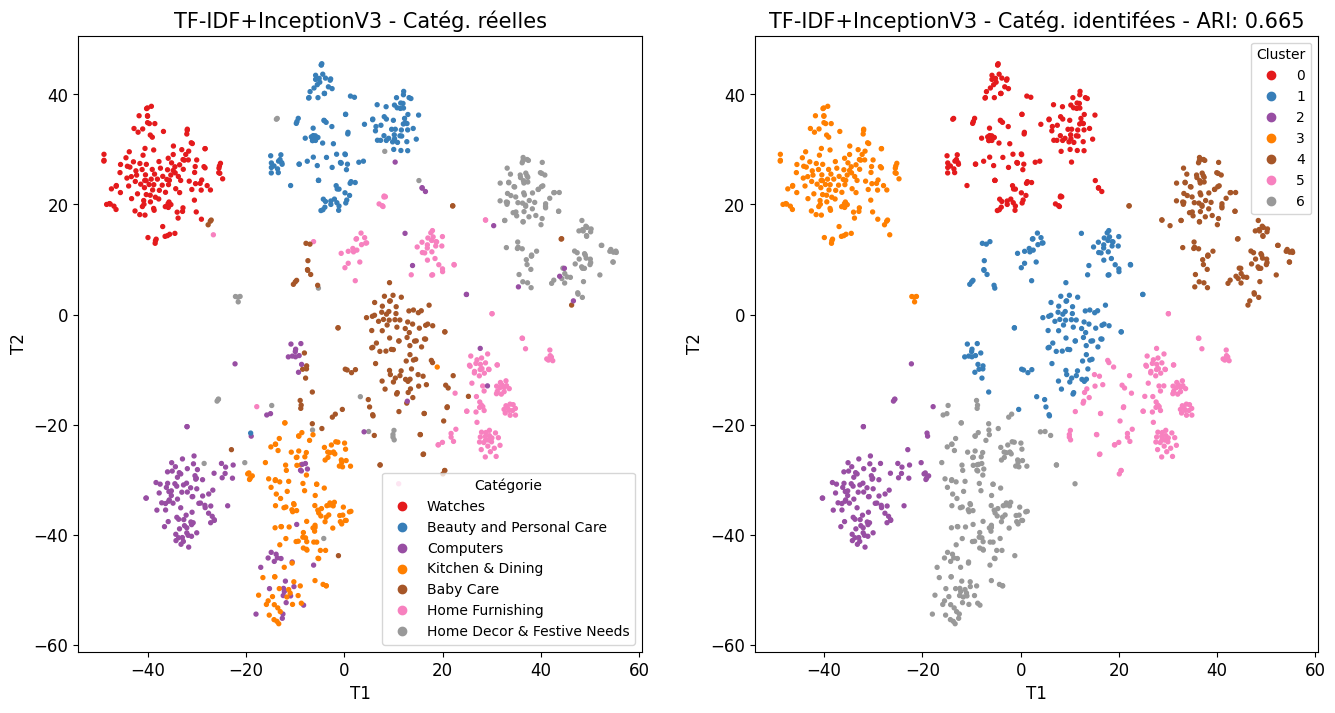

ARI : 0.6648


In [40]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'TF-IDF+InceptionV3'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Mais cette concaténation peut favoriser la partie texte, car elle possède 2 fois plus de dimensions. Les distances euclidiennes auront plus de contribution dans l'espace des textes. Voyons ce que donne de concaténer les 2x2 dimensions des t-SNE.  

## Clustering de l'union des 2 t-SNE

ARI :  0.4712 time :  491.0
ARI :  0.5645 time :  189.0
ARI :  0.6084 time :  164.0


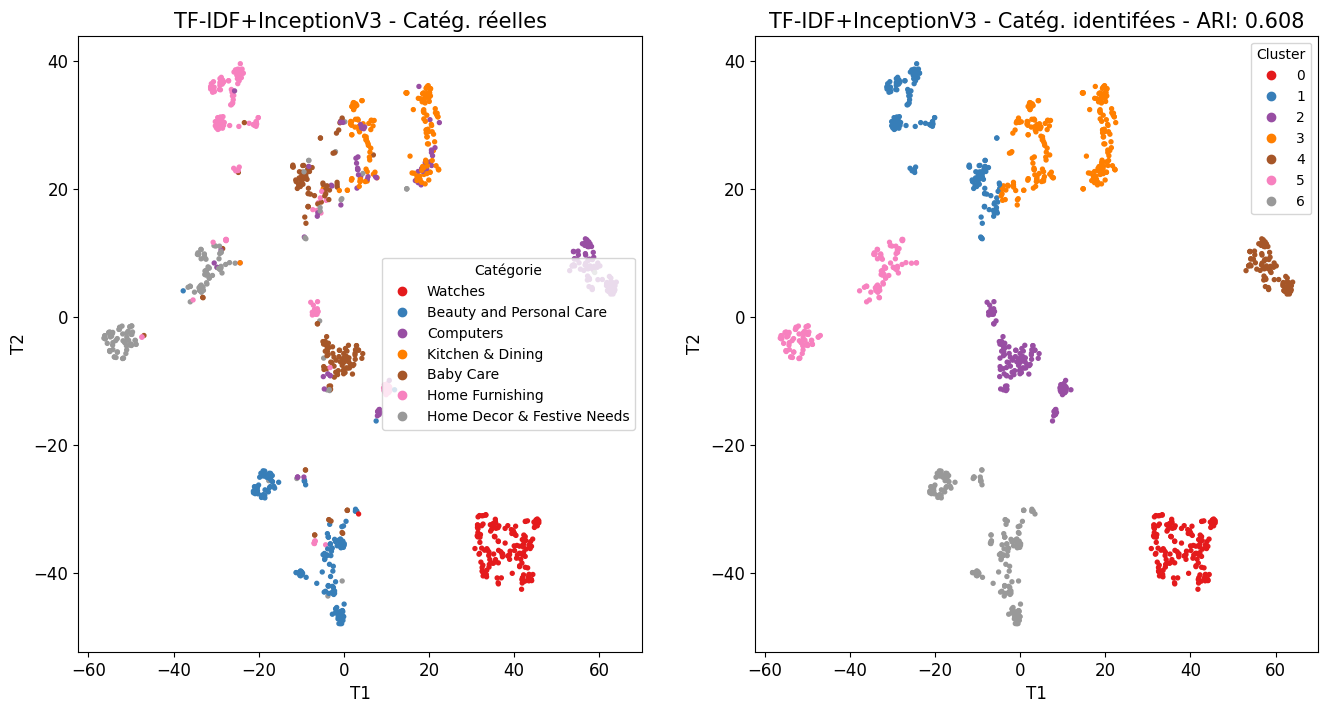

ARI : 0.6084


In [41]:
n_cat = len(np.unique(y_cat_num))
ARI, X_tsne_txt, labels = ARI_fct(best_embeddings, y_cat_num, n_cat, perplexity=30, n_iter=3000)
ARI, X_tsne_img, labels = ARI_fct(features_InV3, y_cat_num, n_cat, perplexity=30, n_iter=3000)
X = np.hstack((X_tsne_txt, X_tsne_img))
ARI, X_tsne_all, labels = ARI_fct(X, y_cat_num, n_cat, perplexity=30, n_iter=3000)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

feature_extractor = 'TF-IDF+InceptionV3'
TSNE_visu_fct(X_tsne_all, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

In [42]:
best_mix = 'TF-IDF+InceptionV3'

In [46]:
# Création des planches d'images
lc = 'label_'+best_mix
image_col = 'image'
df_tk[lc] = labels
create_output_images(df_tk, lc, image_col, best_mix, input_path=data_raw_dir, output_path=data_output_dir, verbose=1)

Création des images correspondant aux clusters...
Cluster 0 : 149 produits
Cluster 1 : 160 produits
Cluster 2 : 124 produits
Cluster 3 : 216 produits
Cluster 4 : 83 produits
Cluster 5 : 143 produits
Cluster 6 : 175 produits


C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Le mix est moins performant que le TF-IDF seul. C'est dommage.

## Equilibrage des features

In [47]:
best_embeddings.shape, features_InV3.shape 

((1050, 512), (1050, 2048))

On réduit la dimension des features textuelles pour l'équilibrer avec les features visuelles, avec une PCA. Mais on doit spécifier une dimension au plus égales à la plus petite valeurs entre le nombre de samples, et les nombres de features :

In [50]:
n = min(best_embeddings.shape[0], best_embeddings.shape[1], features_InV3.shape[1])

In [51]:
pca = decomposition.PCA(n_components=n) # features_InV3.shape[1]
# best_embeddings_reduc = pca.fit_transform(best_embeddings)
best_embeddings_sc = MinMaxScaler().fit_transform(best_embeddings)
best_embeddings_reduc = pca.fit_transform(best_embeddings_sc)

pca = decomposition.PCA(n_components=n) # features_InV3.shape[1]
# features_InV3_reduc = pca.fit_transform(features_InV3)
features_InV3_sc = MinMaxScaler().fit_transform(features_InV3)
features_InV3_reduc = pca.fit_transform(features_InV3_sc)

ARI :  0.6588 time :  11.0


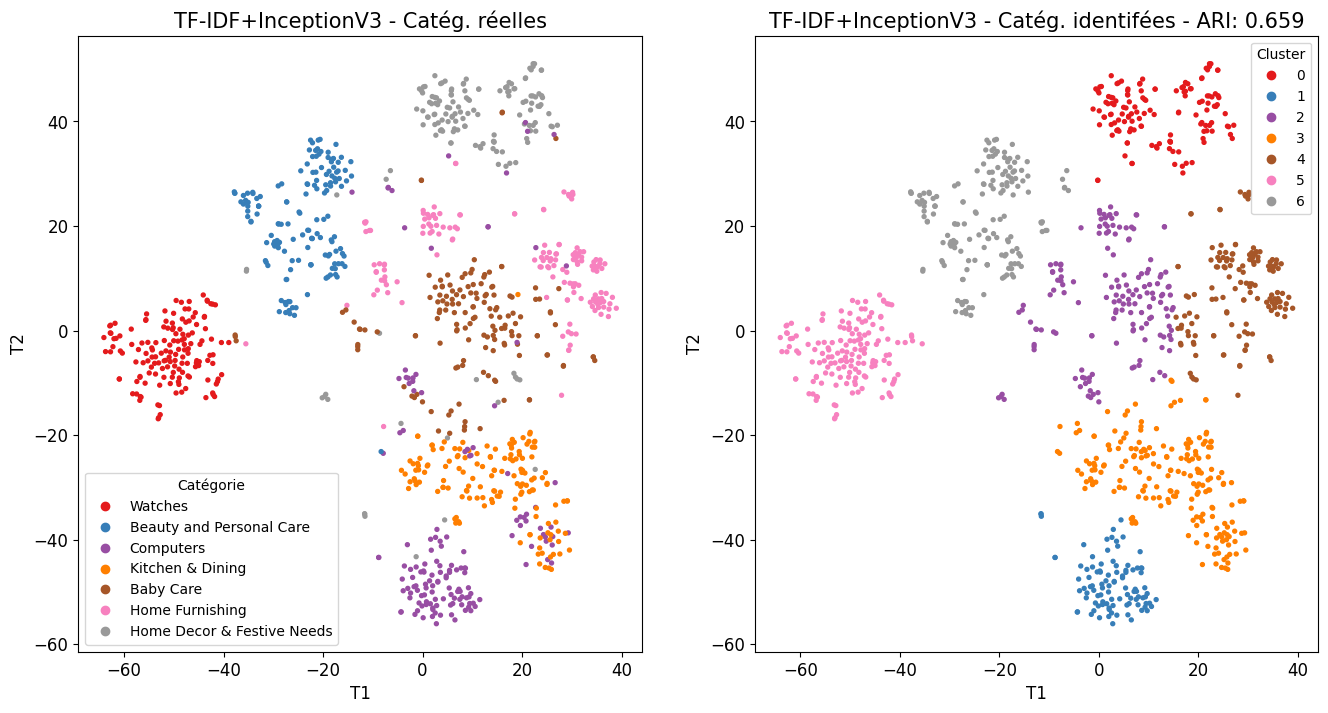

ARI : 0.6588


In [52]:
n_cat = len(np.unique(y_cat_num))
X = np.hstack((best_embeddings_reduc, features_InV3_reduc))
ARI, X_tsne_all, labels = ARI_fct(X, y_cat_num, n_cat, perplexity=30, n_iter=3000)
# X_sc = scMinMaxScaler()aler.fit_transform(X)
# ARI, X_tsne_all, labels = ARI_fct(X_sc, y_cat_num, n_cat, perplexity=30, n_iter=3000)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# y_cat = df_img['categs_1st'].values
feature_extractor = 'TF-IDF+InceptionV3'
TSNE_visu_fct(X_tsne_all, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Le résultat est meilleur que la meilleure classification non supervisée par le texte (0.63), et sans équilibrage des 2 matrices (0.61).

## Classification supervisée

On vérifie si une classification supervisée donne de meilleurs résultats que le clustering, dont le score ARI est peut-être dépendant de catégories un peu trop larges.

In [56]:
param_grid_xgbc = {'n_estimators': [200], #[20, 50, 100, 200]
                   'learning_rate': [0.1], #[0.01, 0.1, 0.3]
                   'subsample': [0.5], #[0.5, 0.7, 1.]
                  }
param_grid_rfc = {'n_estimators': [200], #[20, 50, 100, 200]
                  'max_depth': [None], #[None, 1, 2, 5],
                  'min_samples_split': [2], #[2, 5, 10], 
                 }

In [57]:
y_enc = df_tk['categs_1st_num']
s = 0.
for embeddings, name in [
                         [df_em_1gram, 'df_em_1gram'],
                         [df_tfidf_1gram, 'df_tfidf_1gram'],
                         [embeddings_word2vec, 'embeddings_word2vec'],
                         [embeddings_glove, 'embeddings_glove'],
                         [features_bert, 'features_bert'],
                         [features_bert_hub, 'features_bert_hub'],
                         [features_USE, 'features_USE'],
                         ]:
    print(bcolors.BOLD+name+'\n'+'-'*len(name)+bcolors.ENDC)
    X = np.hstack((embeddings, features_InV3))
    X_sc = MinMaxScaler().fit_transform(X)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_sc, y_enc, test_size=0.2, random_state=18011975)  # 18011975 , stratify=y_enc

    time1 = time.time()
    mdl = GridSearchCV(
#                        XGBClassifier(), param_grid_xgbc,
                       RandomForestClassifier(), param_grid_rfc,
                       cv=5,
                       scoring='accuracy'
                       )
    mdl.fit(X_train, y_train)
    main_score_val = mdl.cv_results_['mean_test_score'].max()
    print(f"main_score_val = {main_score_val:.4f}")
    print(f"best_params_ = {mdl.best_params_}")
    
    y_test_pred = mdl.best_estimator_.predict(X_test)
    time2 = time.time() - time1
    s_old = s
    s = metrics.accuracy_score(y_test, y_test_pred)
    
    y_train_pred = mdl.best_estimator_.predict(X_train)
    s1 = metrics.accuracy_score(y_train, y_train_pred)
    print(f"Accuracy sur train set = {s1:.4f}")
    print(f"Accuracy sur test set  = {s:.4f}, elapsed = {time2:.1f}")


df_em_1gram
-----------
main_score_val = 0.8643
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.8381, elapsed = 24.3
df_tfidf_1gram
--------------
main_score_val = 0.8619
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.8476, elapsed = 24.9
embeddings_word2vec
-------------------
main_score_val = 0.8869
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.9048, elapsed = 29.6
embeddings_glove
----------------
main_score_val = 0.8833
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy sur train set = 1.0000
Accuracy sur test set  = 0.9095, elapsed = 34.2
features_bert
-------------
main_score_val = 0.8857
best_params_ = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accu

## Méthode hybride

Les catégories (réelles) ont un sens pour le clustering textuel (même pour le TF-IDF, qui partage des mots du thème "déco" même quand les objets sont très distincts, comme un Boudha et un tapis).
Ces catégories ont moins de sens pour les images : le Boudha et le tapis ne partageront quasiment pas de features visuelles. En non-supervisé, ces 2 sous-catégories seront séparées par les algorithmes traitant images.

**Idée :** On va essayer d'exploiter les avantages des algorithmes visuels, pour les **partager** avec les algorithmes textuels :
- on réalise identification de l'objet sur l'image (par un CNN complet)
- on projette le (ou les) nom d'objet dans l'espace de vocabulaire de l'algo textuel (si tant est qu'il en ait besoin).
L'algo textuel sera possiblement aidé par l'identification, dans les cas où la description ne désigne pas assez bien l'objet.

On pourra faire le test de se passer de la description complète ! Là, on améliorer l'expérience utilisateur (vendeur) !

On choisit l'embeddings USE pour la partie texte et le réseau `InceptionV3` pour la partie images.

In [58]:
model_InV3 = InceptionV3()

In [62]:
img_dir = data_raw_dir+'images/'
img_paths = [os.path.join(img_dir, file) for file in df_tk['image'].values]

In [63]:
img_size = 299
imgs = read_and_prep_images(img_paths, img_size, img_size, preprocess_input_InV3)

C:\Users\Public\WPy64-31080\python-3.10.8.amd64\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [64]:
y = model_InV3.predict(imgs)

33/33 [==============================] - 61s 2s/step


In [65]:
y.shape

(1050, 1000)

In [66]:
print('Top 3 :', decode_predictions_InV3(y, top=1)[0])

Top 3 : [('n03998194', 'prayer_rug', 0.19909893)]


In [67]:
preds = decode_predictions_InV3(y, top=1)
len(preds)

1050

In [68]:
preds3 = decode_predictions_InV3(y, top=3)
preds3

[[('n03998194', 'prayer_rug', 0.19909893),
  ('n04532106', 'vestment', 0.14344785),
  ('n04209239', 'shower_curtain', 0.091246456)],
 [('n02808304', 'bath_towel', 0.928696),
  ('n04525038', 'velvet', 0.015622629),
  ('n04599235', 'wool', 0.0028662265)],
 [('n02808304', 'bath_towel', 0.8890721),
  ('n04599235', 'wool', 0.014774076),
  ('n02730930', 'apron', 0.010923943)],
 [('n04344873', 'studio_couch', 0.99031866),
  ('n04033995', 'quilt', 0.00039669694),
  ('n03388549', 'four-poster', 0.00039535243)],
 [('n04033995', 'quilt', 0.46158046),
  ('n03998194', 'prayer_rug', 0.043969586),
  ('n04344873', 'studio_couch', 0.016498502)],
 [('n02708093', 'analog_clock', 0.53116363),
  ('n03197337', 'digital_watch', 0.2589665),
  ('n03706229', 'magnetic_compass', 0.07394357)],
 [('n02708093', 'analog_clock', 0.5341194),
  ('n04328186', 'stopwatch', 0.16957363),
  ('n03197337', 'digital_watch', 0.097577535)],
 [('n02708093', 'analog_clock', 0.79784274),
  ('n03197337', 'digital_watch', 0.05931292)

In [69]:
obj_name = [ a[0][1] for a in preds ]
obj_name

['prayer_rug',
 'bath_towel',
 'bath_towel',
 'studio_couch',
 'quilt',
 'analog_clock',
 'analog_clock',
 'analog_clock',
 'digital_watch',
 'stopwatch',
 'sunglasses',
 'analog_clock',
 'stopwatch',
 'analog_clock',
 'digital_clock',
 'analog_clock',
 'digital_clock',
 'digital_watch',
 'stopwatch',
 'digital_clock',
 'stopwatch',
 'analog_clock',
 'analog_clock',
 'digital_watch',
 'stopwatch',
 'digital_watch',
 'analog_clock',
 'digital_watch',
 'digital_watch',
 'analog_clock',
 'magnetic_compass',
 'stopwatch',
 'stopwatch',
 'studio_couch',
 'quilt',
 'doormat',
 'vase',
 'thimble',
 'airship',
 'pillow',
 'pajama',
 'pillow',
 'jersey',
 'sunscreen',
 'coffee_mug',
 'coffee_mug',
 'coffee_mug',
 'soap_dispenser',
 'coffee_mug',
 'lotion',
 'coffee_mug',
 'sandal',
 'frying_pan',
 'can_opener',
 'can_opener',
 'can_opener',
 'neck_brace',
 'lipstick',
 'lipstick',
 'sunscreen',
 'lipstick',
 'lipstick',
 'perfume',
 'hamper',
 'coffee_mug',
 'coffee_mug',
 'bath_towel',
 'chest

Remplacement des `_` par un espace ` ` :

In [70]:
obj_name = [ a.replace('_', ' ') for a in obj_name ]

In [71]:
obj_name3 = [ ' '.join([a[0][1], a[1][1], a[2][1]]) for a in preds3 ]
obj_name3 = [ a.replace('_', ' ') for a in obj_name3 ]
obj_name3

['prayer rug vestment shower curtain',
 'bath towel velvet wool',
 'bath towel wool apron',
 'studio couch quilt four-poster',
 'quilt prayer rug studio couch',
 'analog clock digital watch magnetic compass',
 'analog clock stopwatch digital watch',
 'analog clock digital watch stopwatch',
 'digital watch stopwatch digital clock',
 'stopwatch digital watch analog clock',
 'sunglasses sunglass analog clock',
 'analog clock stopwatch digital watch',
 'stopwatch barometer magnetic compass',
 'analog clock stopwatch wall clock',
 'digital clock digital watch scoreboard',
 'analog clock wall clock digital watch',
 'digital clock digital watch traffic light',
 'digital watch digital clock paintbrush',
 'stopwatch analog clock digital watch',
 'digital clock digital watch microwave',
 'stopwatch digital watch odometer',
 'analog clock wall clock digital clock',
 'analog clock wall clock stopwatch',
 'digital watch stopwatch barometer',
 'stopwatch analog clock digital watch',
 'digital watch 

In [72]:
seuil = 0.33
obj_name_t = []
for a in preds3:
    objs = ''
    for ind in [0, 1, 2]:
        if a[ind][2]>seuil:
            objs = objs + ' ' + a[ind][1]
    obj_name_t.append(objs)
obj_name_t = [ a.replace('_', ' ') for a in obj_name_t ]
obj_name_t

['',
 ' bath towel',
 ' bath towel',
 ' studio couch',
 ' quilt',
 ' analog clock',
 ' analog clock',
 ' analog clock',
 ' digital watch',
 ' stopwatch',
 ' sunglasses sunglass',
 ' analog clock',
 ' stopwatch',
 ' analog clock',
 ' digital clock',
 ' analog clock',
 ' digital clock digital watch',
 ' digital watch',
 ' stopwatch analog clock',
 ' digital clock',
 ' stopwatch digital watch',
 ' analog clock',
 ' analog clock',
 ' digital watch',
 ' stopwatch',
 ' digital watch',
 ' analog clock',
 ' digital watch',
 ' digital watch',
 ' analog clock',
 ' magnetic compass',
 ' stopwatch',
 ' stopwatch',
 ' studio couch',
 ' quilt',
 ' doormat',
 '',
 '',
 ' airship',
 ' pillow',
 ' pajama',
 ' pillow',
 ' jersey',
 ' sunscreen',
 ' coffee mug',
 ' coffee mug',
 ' coffee mug',
 '',
 ' coffee mug',
 ' lotion',
 ' coffee mug',
 ' sandal',
 ' frying pan',
 '',
 '',
 '',
 ' neck brace',
 ' lipstick',
 ' lipstick',
 '',
 ' lipstick',
 ' lipstick',
 ' perfume',
 ' hamper',
 ' coffee mug',
 ' c

In [73]:
df_all = df_tk_res.copy()

In [89]:
MIN_WORD_LEN = 1 # "HD" est informatif

# Stop words
STOP_WORDS = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', ';', '?', '!', '(', ')']
EXCLUDED_WORDS = [
    'products',
    'product',
    'free',
    'rs',
    'r',
    'buy',
    'delivery',
    'deliveri',
    'deliver',
    'cash',
    'shipping',
    'shipment',
    'ship',
    'prices',
    'price',
    'gifts',
    'gift',
    'giftings',
    'gifting',
    'gifted',
    'giving',
    'gived',
    'give',
    'gave',
    'best',
    'genuine',
    'day',
    'online',
    'india',
    'number',
    'key',
    'feature',
    'replacement',
    'guarantee',
    'discount',
    'sale',
    'specification',    
    ]

In [74]:
df_all['identified_object'] = obj_name
df_all['identified_object_3'] = obj_name3
df_all['identified_object_trusted'] = obj_name_t

In [77]:
df_all['name_and_identification'] = df_all['product_name'] + ' ' + df_all['identified_object']
df_all['name_and_desc_and_identif'] = df_all['name_AND_description'] + ' ' + df_all['identified_object']

df_all['name_and_identification_3'] = df_all['product_name'] + ' ' + df_all['identified_object_3']
df_all['name_and_desc_and_identif_3'] = df_all['name_AND_description'] + ' ' + df_all['identified_object_3']

df_all['name_and_identification_trusted'] = df_all['product_name'] + ' ' + df_all['identified_object_trusted']
df_all['name_and_desc_and_identif_trusted'] = df_all['name_AND_description'] + ' ' + df_all['identified_object_trusted']

In [78]:
df_all.head()

categs_1st                                 categs_2nd  \
0  Home Furnishing  Home Furnishing >> Curtains & Accessories   
1        Baby Care              Baby Care >> Baby Bath & Skin   
2        Baby Care              Baby Care >> Baby Bath & Skin   
3  Home Furnishing               Home Furnishing >> Bed Linen   
4  Home Furnishing               Home Furnishing >> Bed Linen   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                name_AND_description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        sentence_bow  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specifications of s...   
2  eurospa cotton terry face towel set key featur...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                    sentence_bow_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set eurospa co...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                   sentence_bow_stem  \
0  eleg polyest multicolor abstract eyelet door c...   
1  sathiya cotton bath towel specif sathiya cotto...   
2  eurospa cotton terri face towel set featur eur...   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size doubl bed...   

                                         sentence_dl  categs_1st_num  ...  \
0  elegance polyester multicolor abstract eyelet ...               3  ...   
1  sathiyas cotton bath towel specifications of s...               2  ...   
2  eurospa cotton terry face towel set key featur...               2  ...   
3  santosh royal fashion cotton printed king size...               3  ...   
4  jaipur print cotton floral king sized double b...               3  ...   

   label_TF-IDF  identified_object                 identified_object_3  \
0             2         prayer rug  prayer rug vestment shower curtain   
1             6         bath towel              bath towel velvet wool   
2             6         bath towel               bath towel wool apron   
3             2       studio couch      studio couch quilt four-poster   
4             2              quilt       quilt prayer rug studio couch   

  identified_object_trusted  \
0                             
1                bath towel   
2                bath towel   
3              studio couch   
4                     quilt   

                             name_and_identification  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1              Sathiyas Cotton Bath Towel bath towel   
2     Eurospa Cotton Terry Face Towel Set bath towel   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                           name_and_desc_and_identif  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL 

In [81]:
transf_cols2 = {'name_identif_bow': transform_bow_fct,
                'name_identif_bow_lem': transform_bow_lem_fct,
                'name_identif_bow_stem': transform_bow_stem_fct,
                'name_identif_dl': transform_dl_fct}
transf_cols3 = {'name_desc_identif_bow': transform_bow_fct,
                'name_desc_identif_bow_lem': transform_bow_lem_fct,
                'name_desc_identif_bow_stem': transform_bow_stem_fct,
                'name_desc_identif_dl': transform_dl_fct}
transf_cols4 = {'name_identif_3_bow': transform_bow_fct,
                'name_identif_3_bow_lem': transform_bow_lem_fct,
                'name_identif_3_bow_stem': transform_bow_stem_fct,
                'name_identif_3_dl': transform_dl_fct}
transf_cols5 = {'name_desc_identif_3_bow': transform_bow_fct,
                'name_desc_identif_3_bow_lem': transform_bow_lem_fct,
                'name_desc_identif_3_bow_stem': transform_bow_stem_fct,
                'name_desc_identif_3_dl': transform_dl_fct}
transf_cols6 = {'name_identif_trusted_bow': transform_bow_fct,
                'name_identif_trusted_bow_lem': transform_bow_lem_fct,
                'name_identif_trusted_bow_stem': transform_bow_stem_fct,
                'name_identif_trusted_dl': transform_dl_fct}
transf_cols7 = {'name_desc_identif_trusted_bow': transform_bow_fct,
                'name_desc_identif_trusted_bow_lem': transform_bow_lem_fct,
                'name_desc_identif_trusted_bow_stem': transform_bow_stem_fct,
                'name_desc_identif_trusted_dl': transform_dl_fct}

In [90]:
df_all = create_transformed_columns(df_all, transf_cols2, 'name_and_identification')
df_all = create_transformed_columns(df_all, transf_cols3, 'name_and_desc_and_identif')
df_all = create_transformed_columns(df_all, transf_cols4, 'name_and_identification_3')
df_all = create_transformed_columns(df_all, transf_cols5, 'name_and_desc_and_identif_3')
df_all = create_transformed_columns(df_all, transf_cols6, 'name_and_identification_trusted')
df_all = create_transformed_columns(df_all, transf_cols7, 'name_and_desc_and_identif_trusted')
df_all.head()

categs_1st                                 categs_2nd  \
0  Home Furnishing  Home Furnishing >> Curtains & Accessories   
1        Baby Care              Baby Care >> Baby Bath & Skin   
2        Baby Care              Baby Care >> Baby Bath & Skin   
3  Home Furnishing               Home Furnishing >> Bed Linen   
4  Home Furnishing               Home Furnishing >> Bed Linen   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                name_AND_description  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        sentence_bow  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specifications of s...   
2  eurospa cotton terry face towel set key featur...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                    sentence_bow_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel sathiyas cotton bat...   
2  eurospa cotton terry face towel set eurospa co...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                                   sentence_bow_stem  \
0  eleg polyest multicolor abstract eyelet door c...   
1  sathiya cotton bath towel specif sathiya cotto...   
2  eurospa cotton terri face towel set featur eur...   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size doubl bed...   

                                         sentence_dl  categs_1st_num  ...  \
0  elegance polyester multicolor abstract eyelet ...               3  ...   
1  sathiyas cotton bath towel specifications of s...               2  ...   
2  eurospa cotton terry face towel set key featur...               2  ...   
3  santosh royal fashion cotton printed king size...               3  ...   
4  jaipur print cotton floral king sized double b...               3  ...   

                        name_desc_identif_3_bow_stem  \
0  eleg polyest multicolor abstract eyelet door c...   
1  sathiya cotton bath towel specif sathiya cotto...   
2  eurospa cotton terri face towel set featur eur...   
3  santosh royal fashion cotton print king size d...   
4  jaipur print cotton floral king size doubl bed...   

                              name_desc_identif_3_dl  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specifications of s...   
2  eurospa cotton terry face towel set key featur...   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                            name_identif_trusted_bow  \
0  elegance polyester multicolor abstract eyelet ...   
1              sathiyas cotton bath towel bath towel   
2     eurospa cotton terry face towel set bath towel   
3  santosh royal fashion cotton printed king size...   
4  jaipur print cotton floral king sized double b...   

                        name_identif_trusted_bow_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1              sathiyas cotton bath towel bath towel   
2     eurospa cotton terry face

### TF-IDF

#### Nom + identification visuelle à 1 prédiction

In [92]:
def main_tf_idf(data, ngram = 1, MAX_NB_WORDS = 75000, verbose=0):
    tfidf_x = TfidfVectorizer(ngram_range = (ngram, ngram), max_features = MAX_NB_WORDS)
    emb = tfidf_x.fit_transform(data).toarray()
    if verbose>0: print("tf-idf with", str(np.array(emb).shape[1]), "features")
    return emb, tfidf_x

ARI :  0.5955 time :  10.0


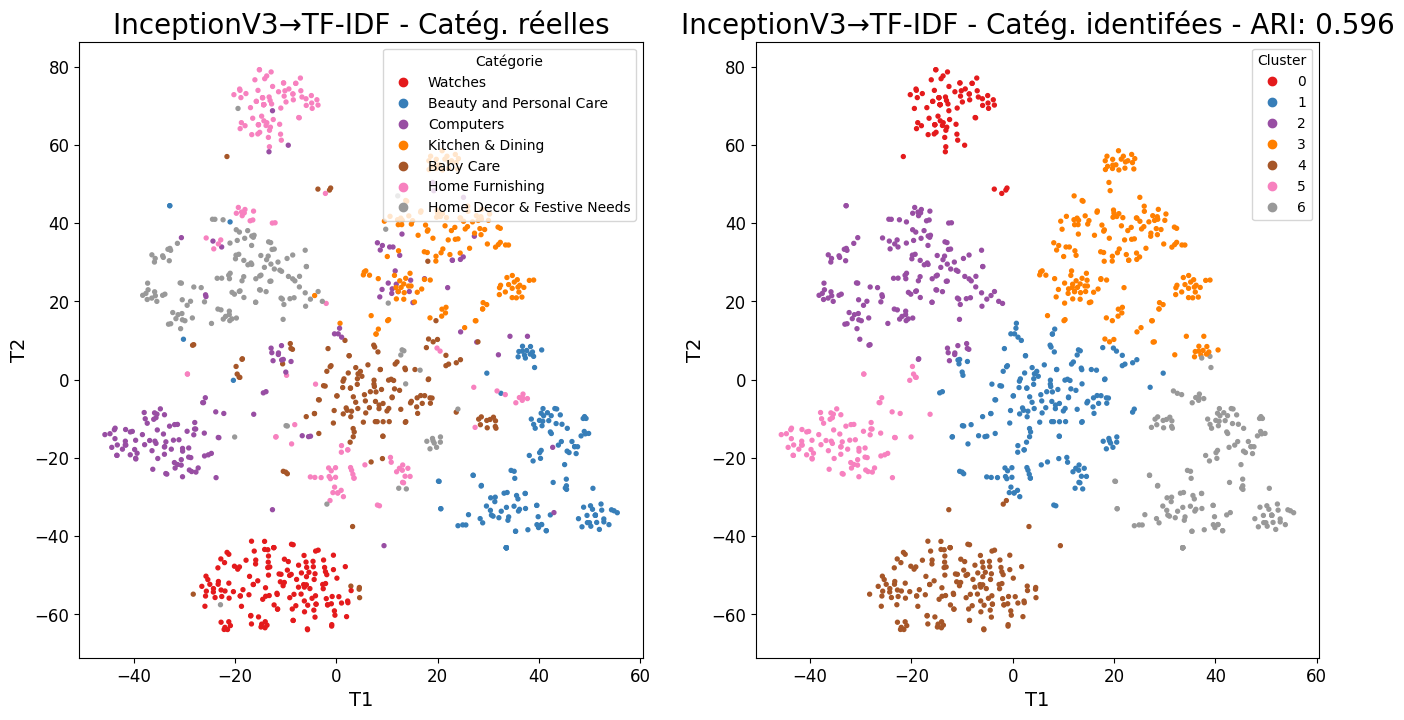

ARI : 0.5955


In [93]:
corpus_col = 'name_identif_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

C'est compétitif avec nom + description (0.63) !

#### Nom + identification visuelle à 3 prédictions

ARI :  0.645 time :  8.0


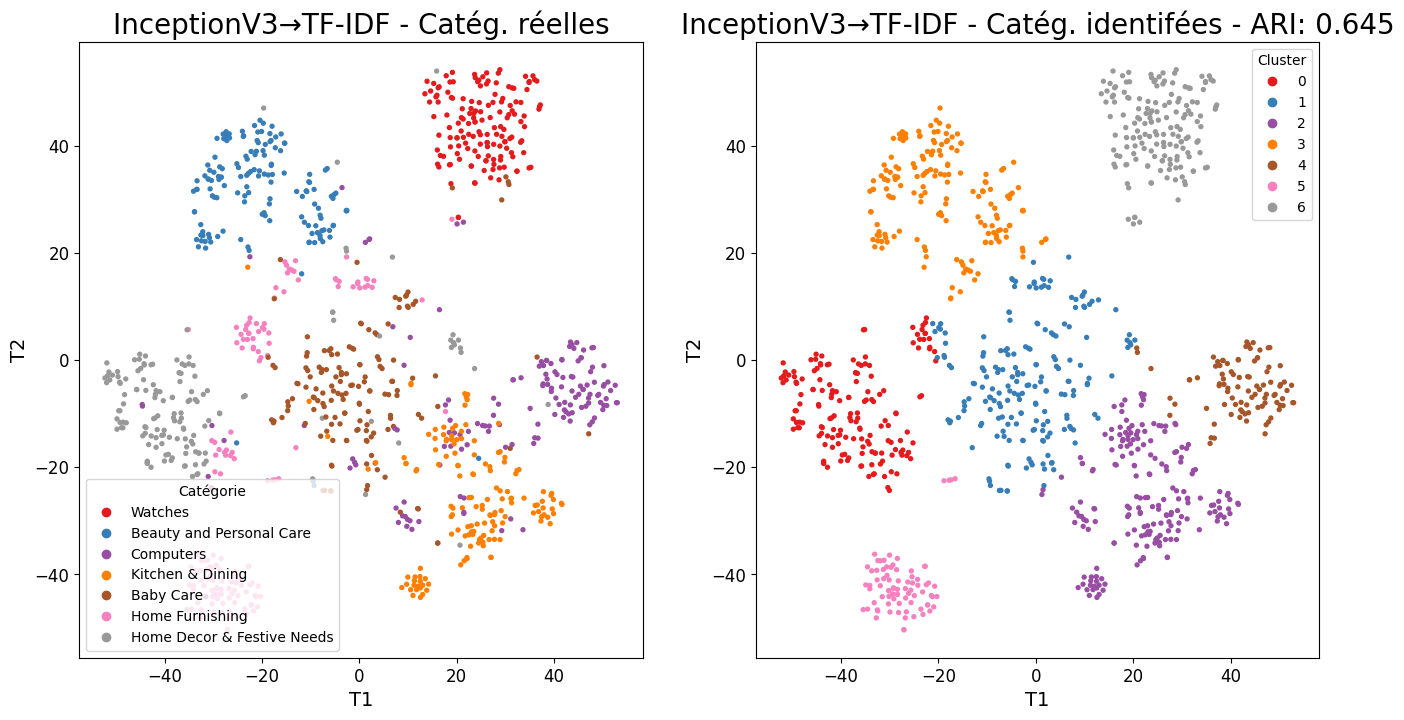

ARI : 0.6450


In [94]:
corpus_col = 'name_identif_3_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

C'est **légèrement mieux** que nom + description (0.63) ! Voilà une "expérience vendeur" intéressante : pas besoin d'entrer une description pour la classification de son produit. Maintenant, il voudra sûrement en entrer une pour ses clients 😆  

#### Nom + identification visuelle fiable

ARI :  0.622 time :  8.0


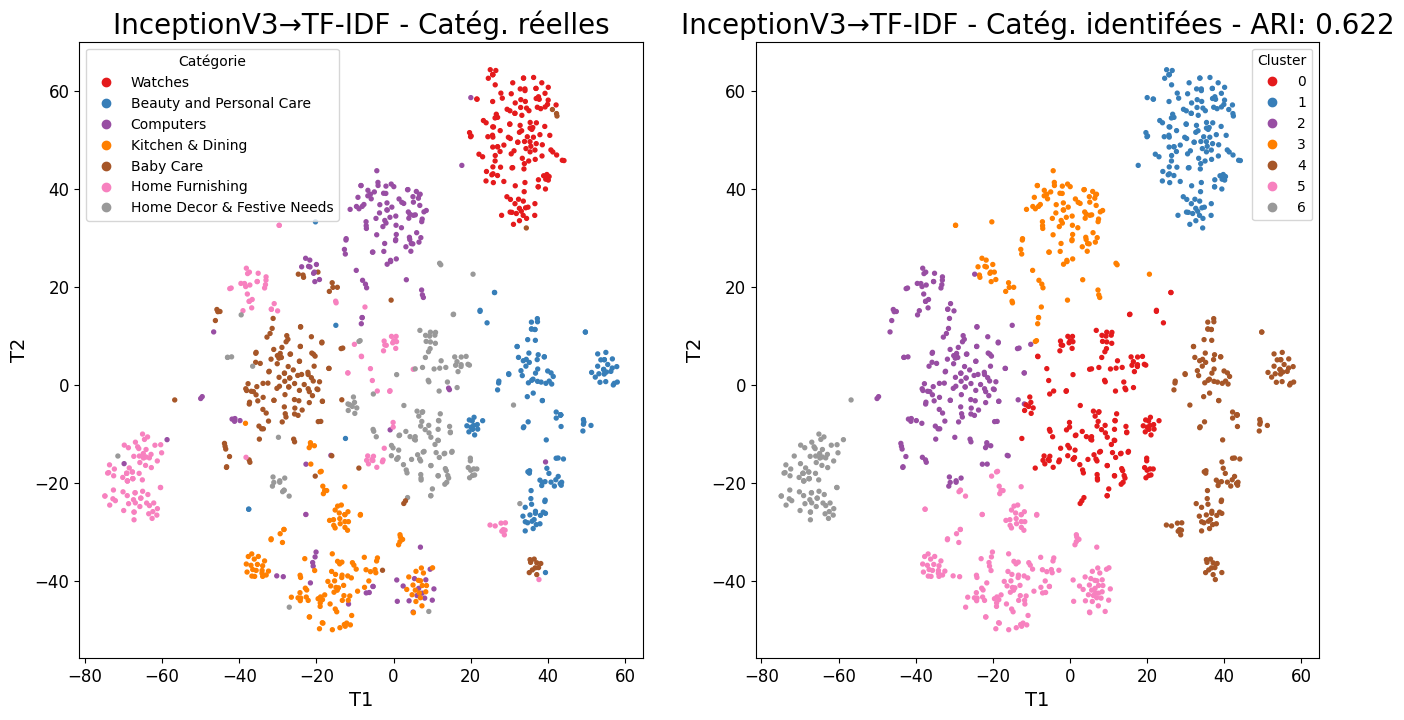

ARI : 0.6220


In [95]:
corpus_col = 'name_identif_trusted_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Ah, ne garder que les prédictions fiables (>0.33) dégrade légèrement le score des 3 meilleures prédictions :/

#### Nom + description + identification visuelle à 1 prédiction

ARI :  0.6147 time :  8.0


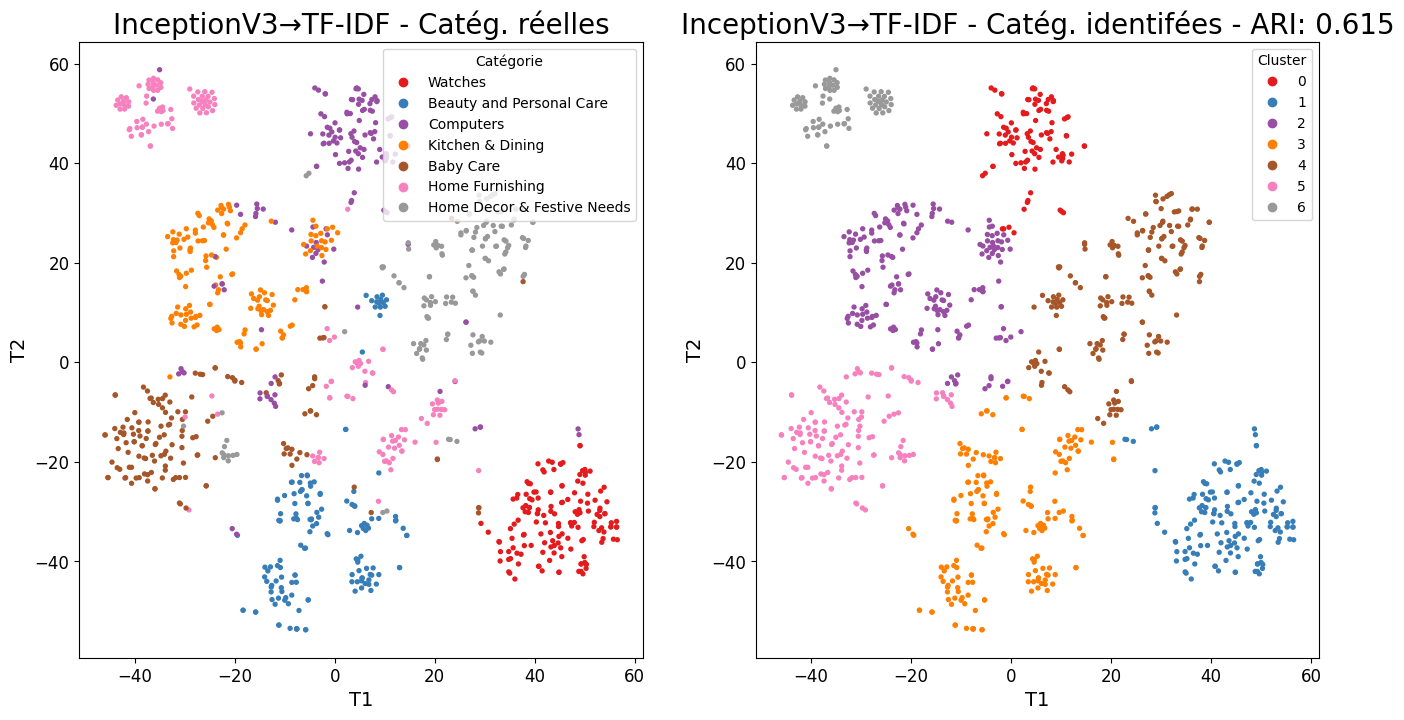

ARI : 0.6147


In [96]:
corpus_col = 'name_desc_identif_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Avec une seule identification, on a légèrement dégradé par rapport au nom+description seul, sans identification (0.63).

#### Nom + description + identification visuelle à 3 prédictions

ARI :  0.6432 time :  8.0


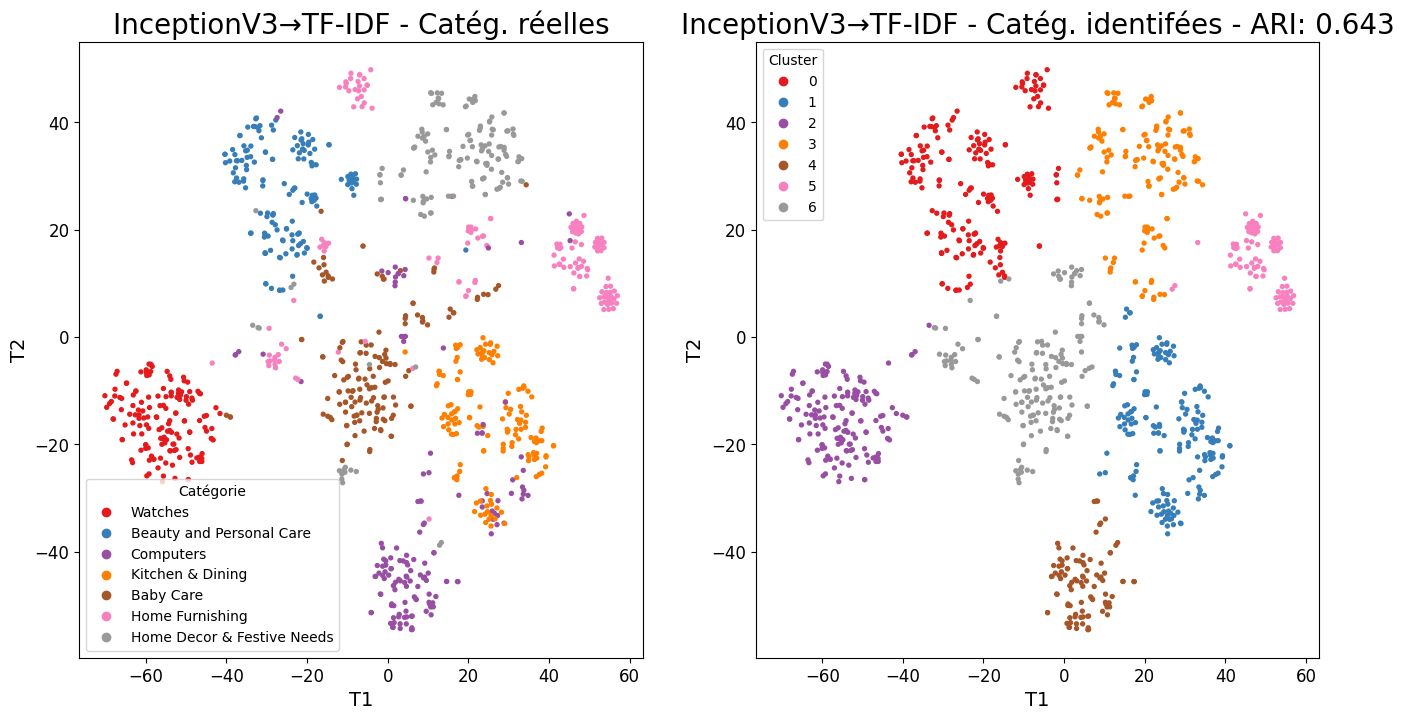

ARI : 0.6432


In [97]:
corpus_col = 'name_desc_identif_3_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Avec les 3 premières identifications, on a **amélioré** (0.64 | 0.63) !

#### Nom + description + identification visuelle fiable

ARI :  0.6413 time :  8.0


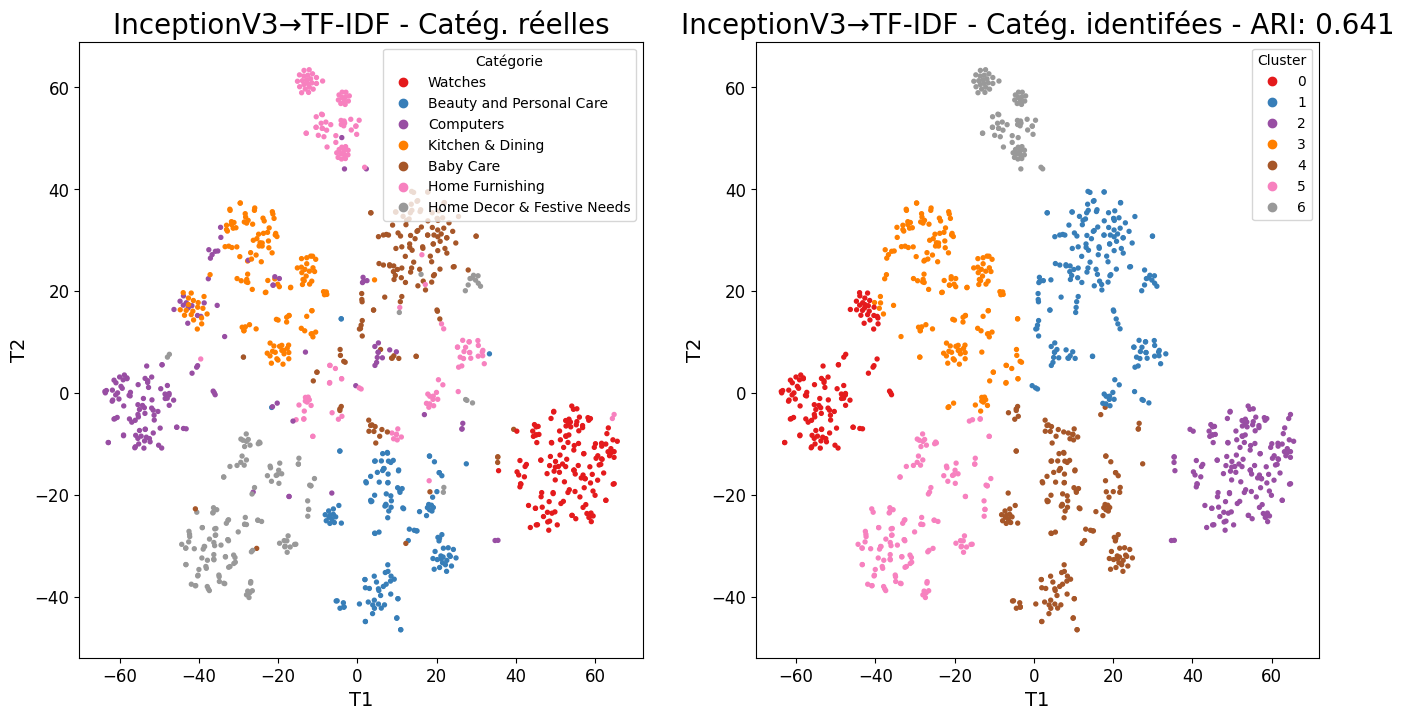

ARI : 0.6413


In [98]:
corpus_col = 'name_desc_identif_trusted_bow_stem'

df_corpus = df_all[corpus_col].tolist()
df_tfidf_1gram, tfidf_1gram = main_tf_idf(df_corpus, 1)

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

ARI, X_tsne, labels = ARI_fct(df_tfidf_1gram, y_cat_num, n_cat)

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'InceptionV3→TF-IDF'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Avec les identifications jugées fiables seulement, ajoutées au nom+description, on obtient un meilleur score également.

### Word2vec

#### Nom seul

In [106]:
def prepare_sentences(sentences, maxlen, verbose=0):
    """Préparation des sentences (tokenization)."""

    if verbose > 0: print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                maxlen=maxlen,
                                padding='post')

    num_words = len(tokenizer.word_index) + 1
    if verbose > 1: print("Number of unique words: %i" % num_words)
    return tokenizer, x_sentences, num_words

In [107]:
def make_embedding_matrix(tokenizer, w2v_size, w2v_words, model_vectors, verbose=0):
    """Création de la matrice d'embedding"""

    if verbose>0: print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0

    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i,4)
    if verbose>1: print("Word embedding rate : ", word_rate)
    if verbose>1: print("Embedding matrix: %s" % str(embedding_matrix.shape))
    return embedding_matrix, vocab_size

In [108]:
def make_and_train_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=0):
    """Création et entraînement du modèle Word2Vec."""

    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                       vector_size=w2v_size,
                                       seed=42,
#                                        seed=18011975,
                                       workers=1)
    #                                    workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    if verbose>1: print("Vocabulary size: %i" % len(w2v_words))
    if verbose>1: print("Word2Vec trained")
    return w2v_model, w2v_words, model_vectors

In [112]:
def make_model_word2vec(maxlen, vocab_size, w2v_size, x_sentences, embedding_matrix, verbose=0):
    """Création du modèle."""

    if verbose>0: print("Making Embedding model ...")
    input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
    word_input = Input(shape=(maxlen,), dtype='float64')
    word_embedding = Embedding(input_dim=vocab_size,
                               output_dim=w2v_size,
                               weights=[embedding_matrix],
                               input_length=maxlen)(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    if verbose>0: embed_model.summary()
    return embed_model

In [113]:
def main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=0):
    w2v_model, w2v_words, model_vectors = make_and_train_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose)
    tokenizer, x_sentences, num_words = prepare_sentences(sentences, maxlen, verbose)
    embedding_matrix, vocab_size = make_embedding_matrix(tokenizer, w2v_size, w2v_words, model_vectors, verbose)
    embed_model = make_model_word2vec(maxlen, vocab_size, w2v_size, x_sentences, embedding_matrix, verbose)
    if verbose>0: print('Predicting embeddings...')
    embeddings = embed_model.predict(x_sentences)
    if verbose>2: print(embeddings.shape)
    return embeddings

In [114]:
w2v_size = 50 # by DOE #300
w2v_window = 2
w2v_min_count = 2
w2v_epochs = 200 #100
maxlen = 50 #24 # adapt to length of sentences

Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            101950    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 101,950
Trainable params: 101,950
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI :  0.4609 time :  10.0


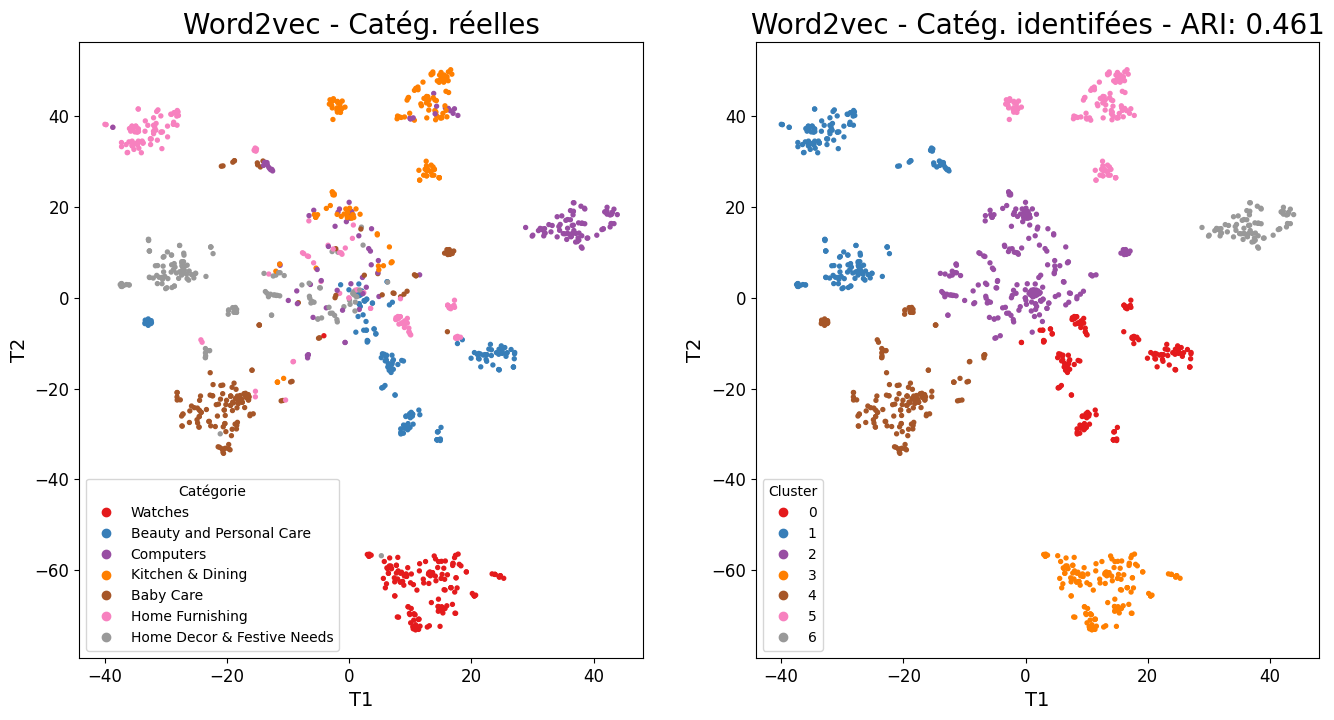

ARI : 0.4609


In [115]:
sentences = df_tk['product_name'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
verbose = 1
embeddings_word2vec = main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)
ARI, X_tsne, labels = ARI_fct(embeddings_word2vec, y_cat_num, n_cat)
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
feature_extractor = 'Word2vec'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Les résultats sont nettement plus mauvais que la classification textuelles seule.

#### Identifications seules

In [117]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences


Colonne pour le corpus = identified_object
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           84600     
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 84,600
Trainable params: 84,600
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI :  0.095 time :  9.0


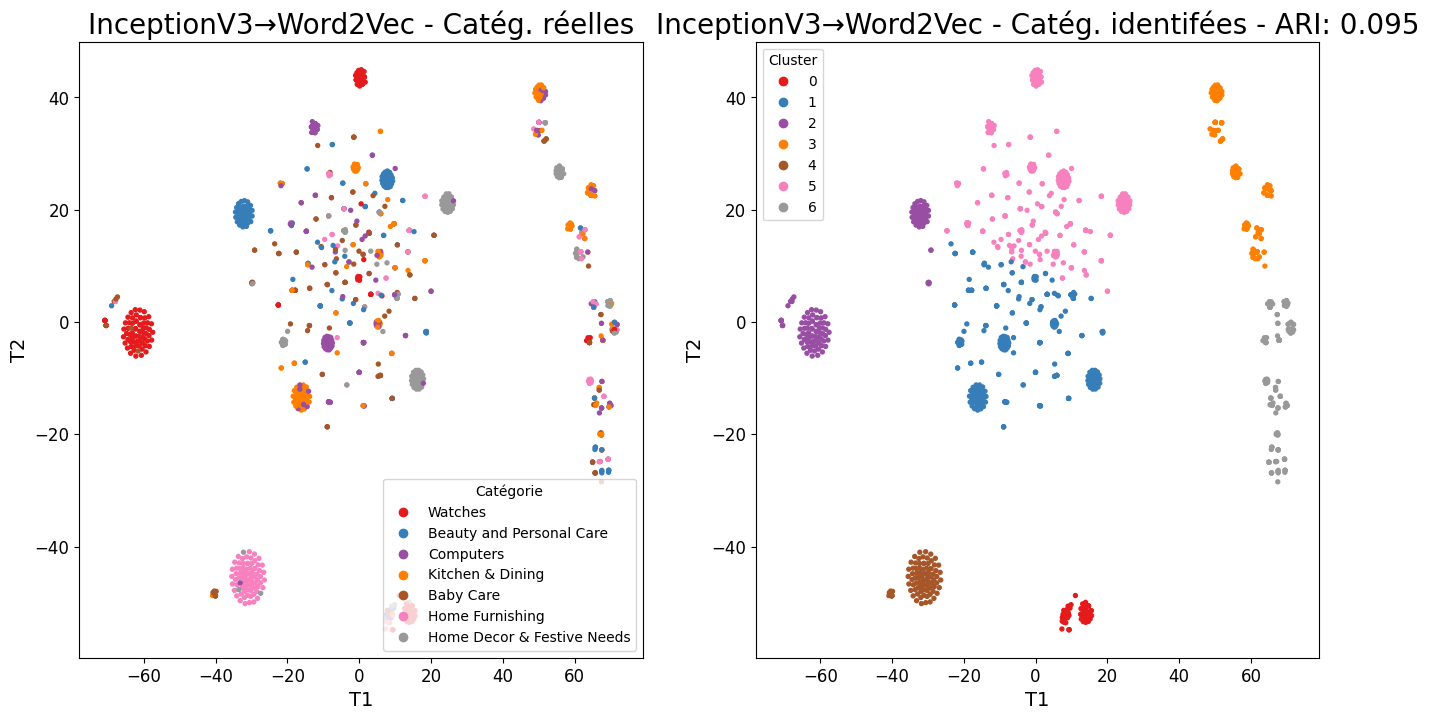

ARI : 0.0950

Colonne pour le corpus = identified_object_3
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 24, 300)           134100    
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 134,100
Trainable params: 134,100
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI :  0

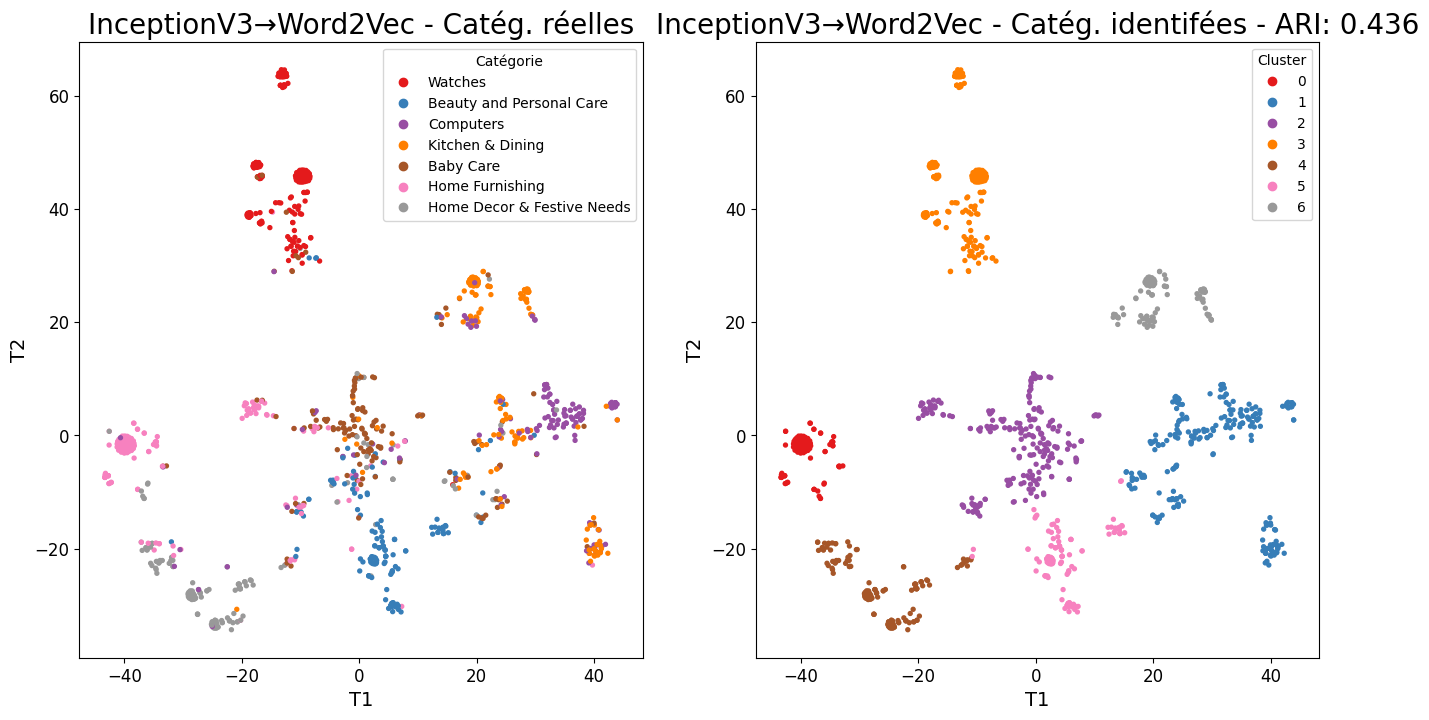

ARI : 0.4364

Colonne pour le corpus = identified_object_trusted
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 24, 300)           62100     
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 62,100
Trainable params: 62,100
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI 

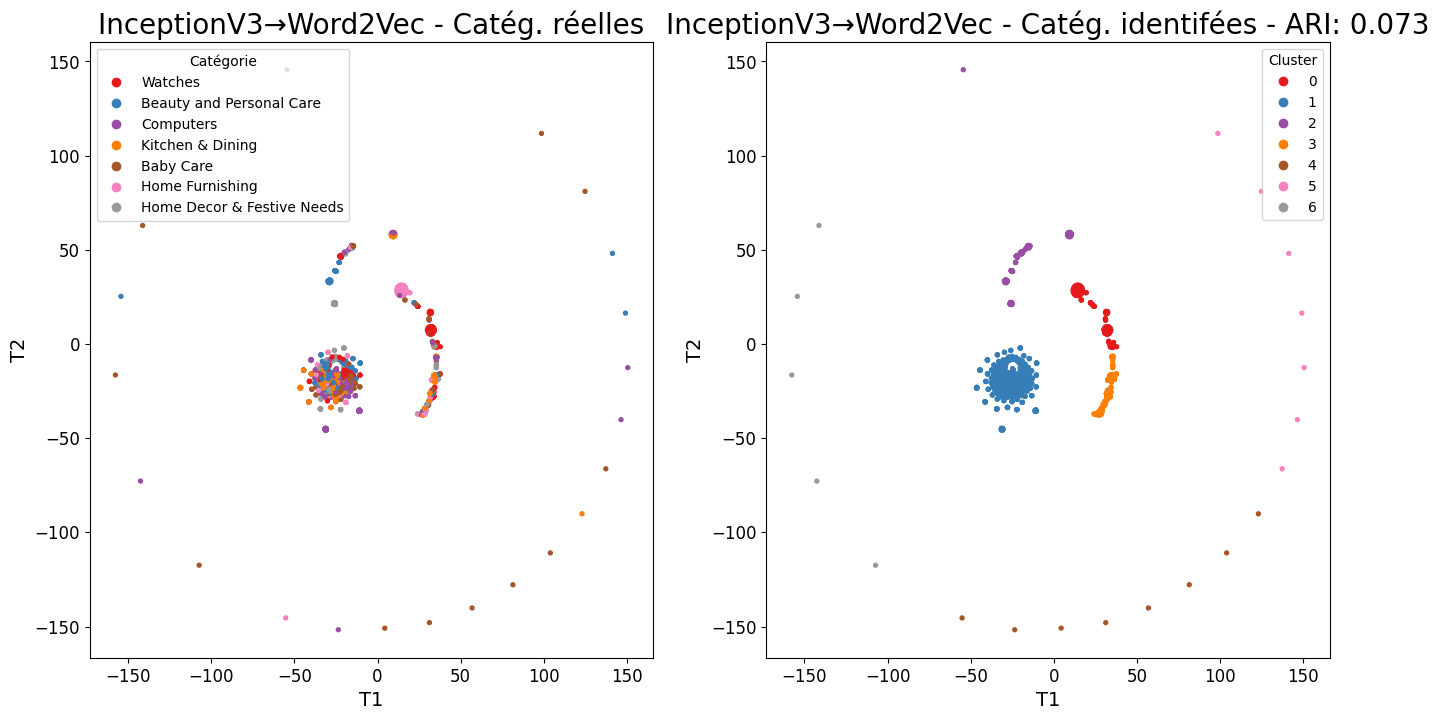

ARI : 0.0726


In [118]:
for corpus_col in ['identified_object', 
                   'identified_object_3',
                   'identified_object_trusted']:
    txt = f"Colonne pour le corpus = {corpus_col}"
    print("\n"+bcolors.HEADER+bcolors.BOLD+txt+bcolors.ENDC)
    sentences = df_all[corpus_col].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

    verbose = 1
    embeddings_word2vec = main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)

    ARI, X_tsne, labels = ARI_fct(embeddings_word2vec, y_cat_num, n_cat)

    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    feature_extractor = 'InceptionV3→Word2Vec'
    TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Seule la prédiction `identified_object_3` reste valable avant l'envoi dans `word2vec`. 

#### Ajout des prédictions sur image


Colonne pour le corpus = name_identif_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 24, 300)           591900    
                                                                 
 global_average_pooling1d_4   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 591,900
Trainable params: 591,900
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI :  0.5861 time :

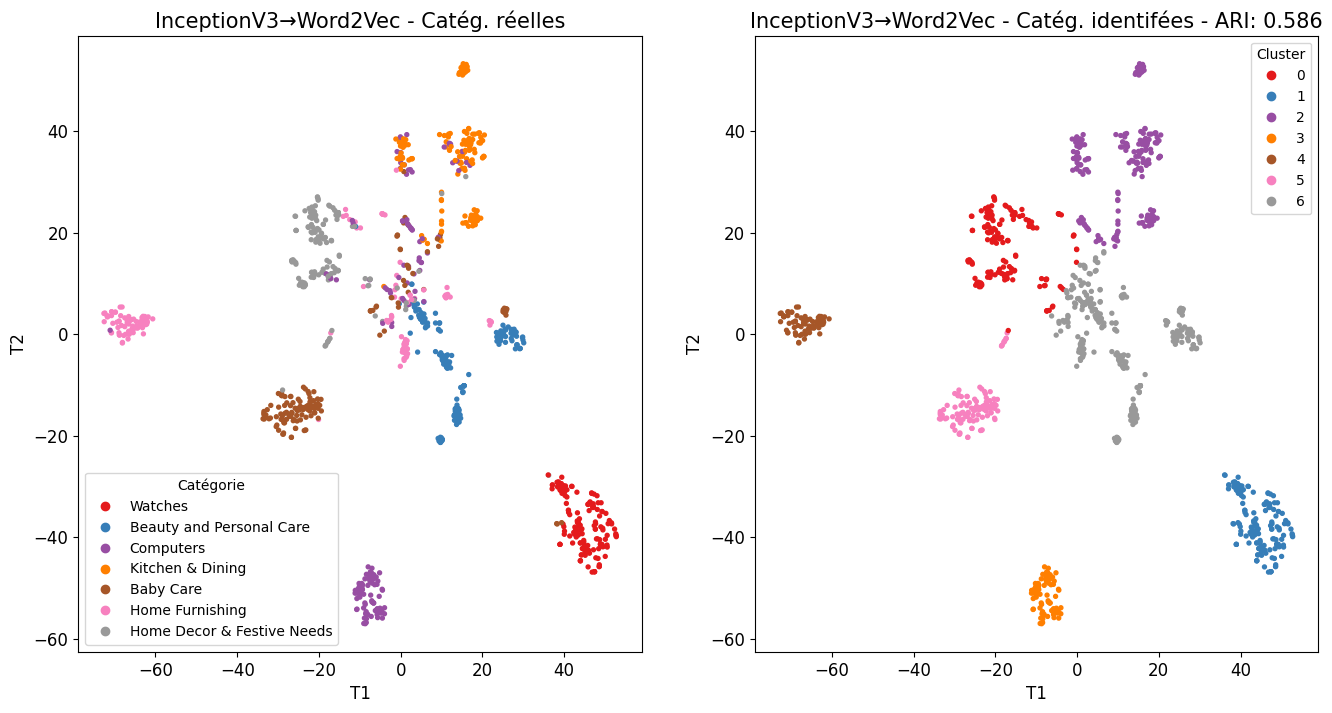

ARI : 0.5861

Colonne pour le corpus = name_identif_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 24, 300)           578100    
                                                                 
 global_average_pooling1d_5   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 578,100
Trainable params: 578,100
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI : 

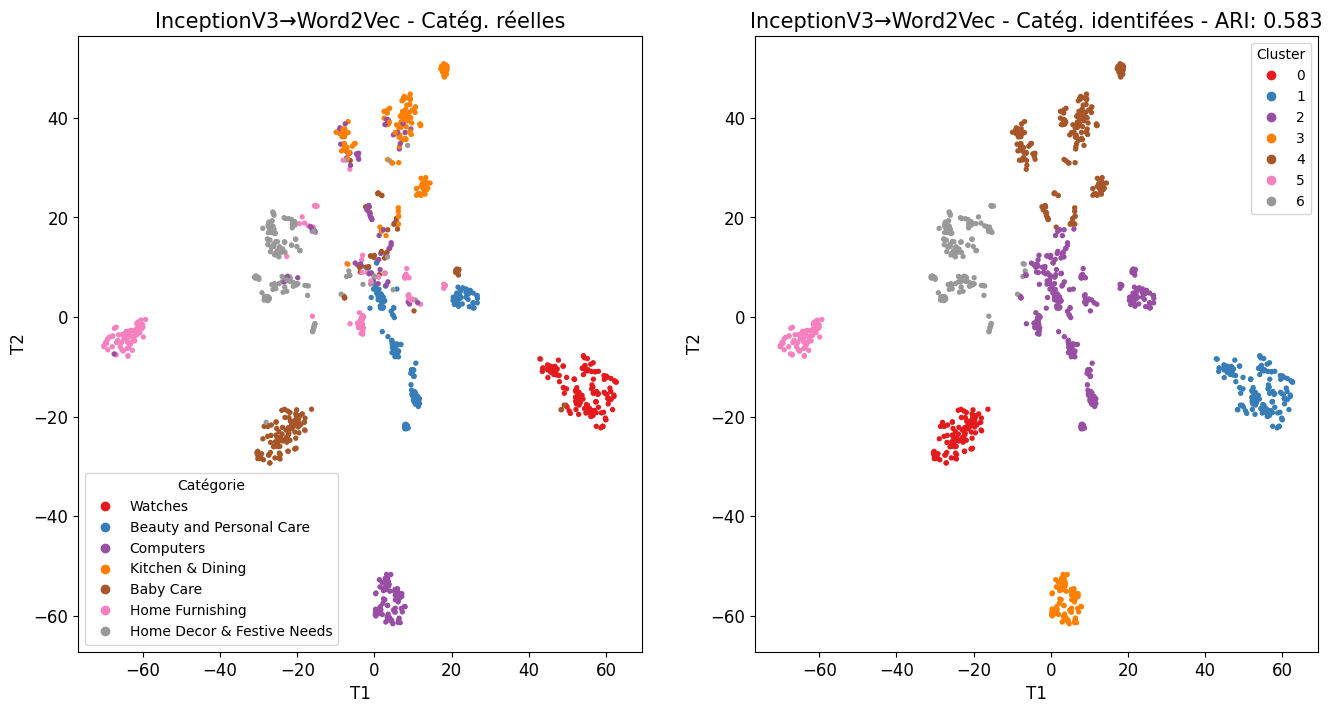

ARI : 0.5830

Colonne pour le corpus = name_desc_identif_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 24, 300)           1362600   
                                                                 
 global_average_pooling1d_6   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,362,600
Trainable params: 1,362,600
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/ste

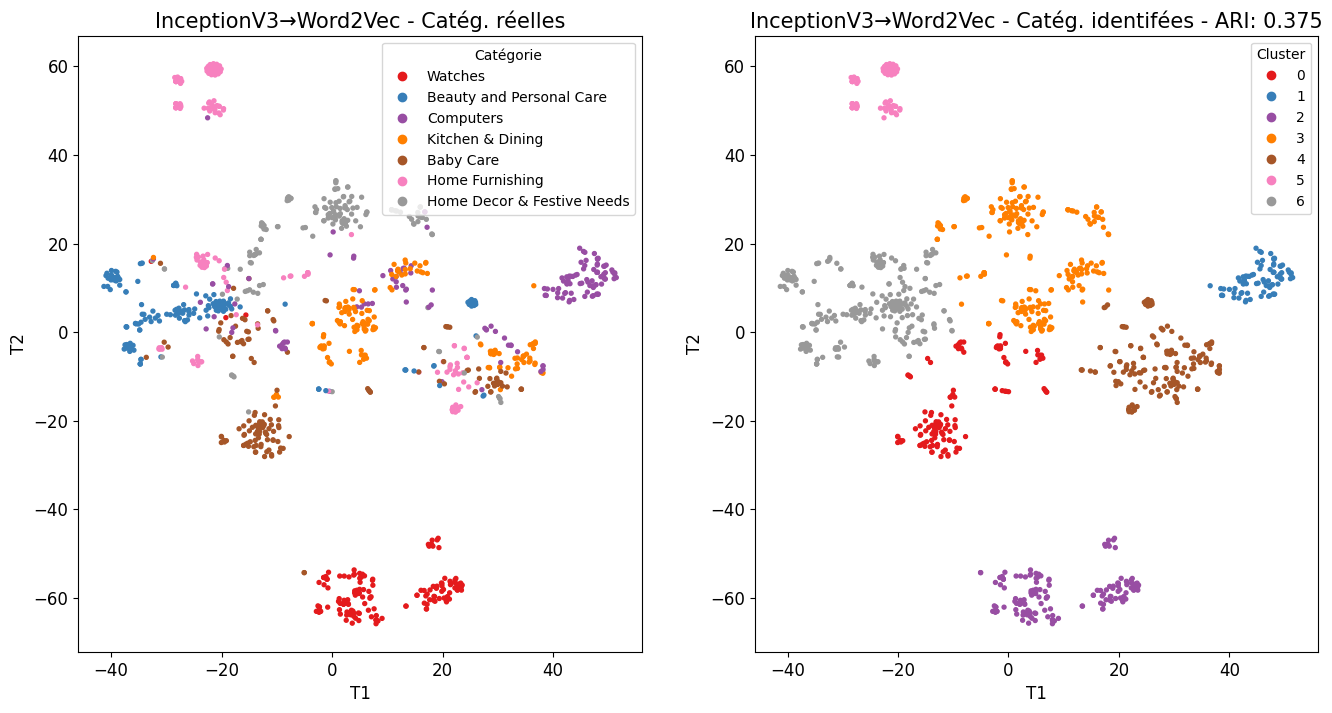

ARI : 0.3752

Colonne pour le corpus = name_desc_identif_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 24, 300)           1196400   
                                                                 
 global_average_pooling1d_7   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,196,400
Trainable params: 1,196,400
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 2ms/st

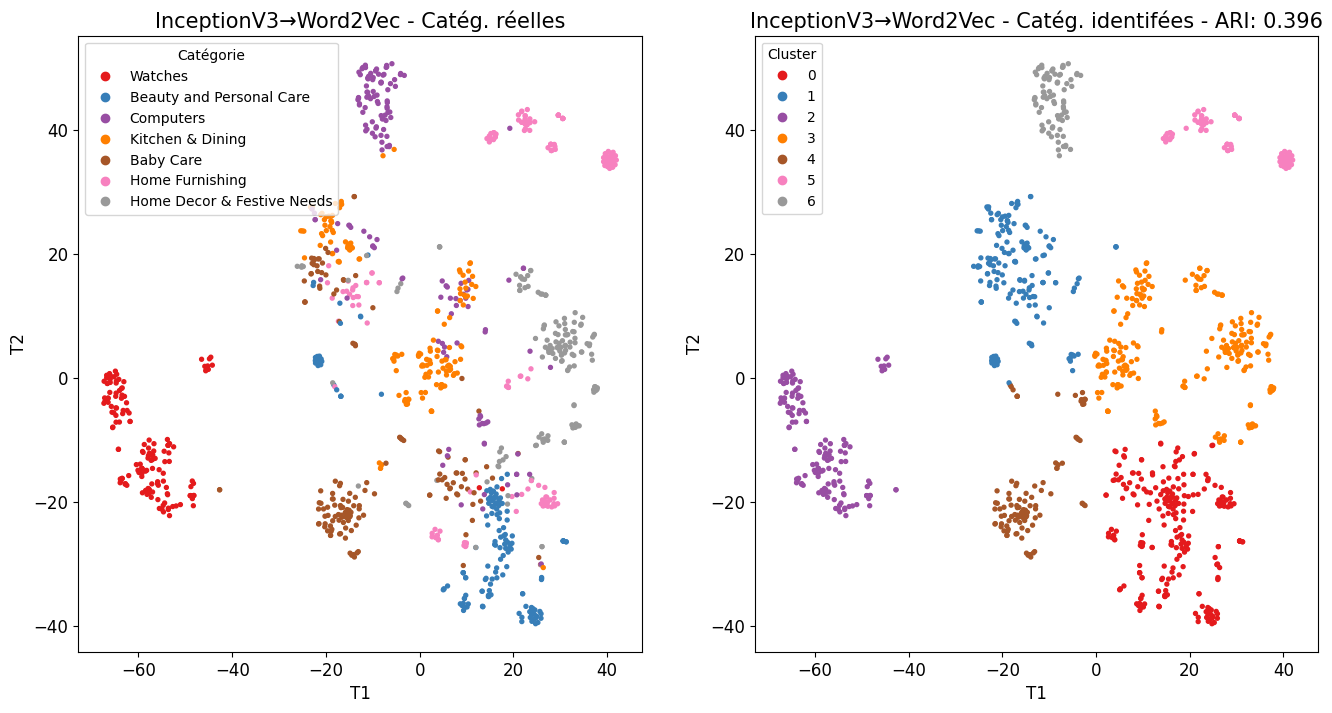

ARI : 0.3955

Colonne pour le corpus = name_identif_3_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 24, 300)           631200    
                                                                 
 global_average_pooling1d_8   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 631,200
Trainable params: 631,200
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/step
ARI :

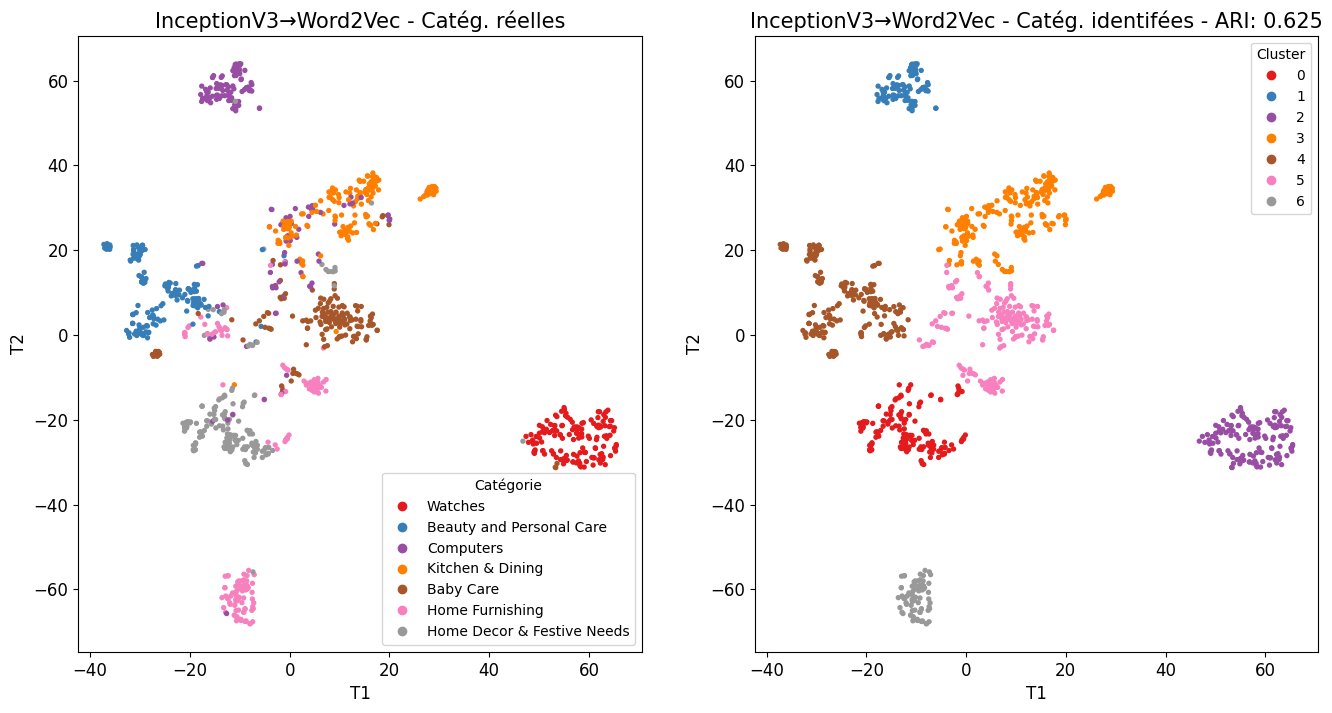

ARI : 0.6251

Colonne pour le corpus = name_identif_3_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 24, 300)           617100    
                                                                 
 global_average_pooling1d_9   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 617,100
Trainable params: 617,100
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 2ms/step
ARI 

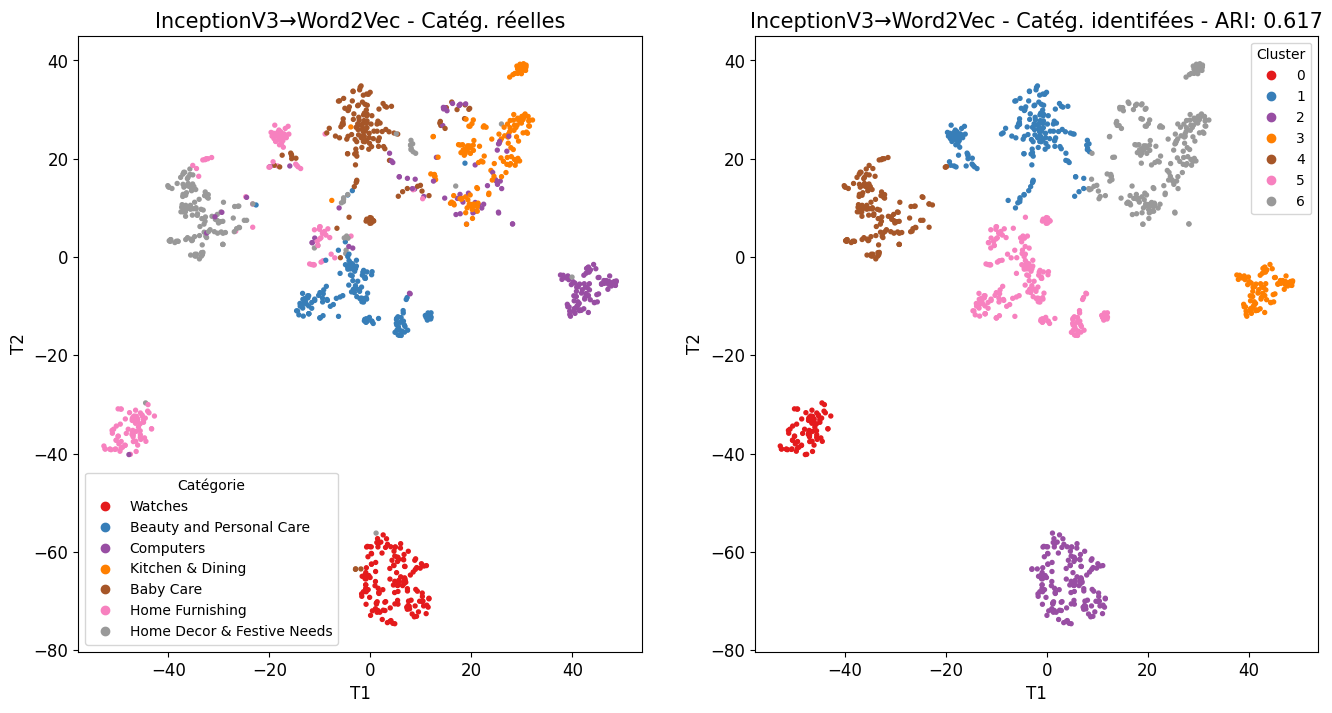

ARI : 0.6172

Colonne pour le corpus = name_desc_identif_3_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 24, 300)           1394700   
                                                                 
 global_average_pooling1d_10  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1,394,700
Trainable params: 1,394,700
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 2ms/

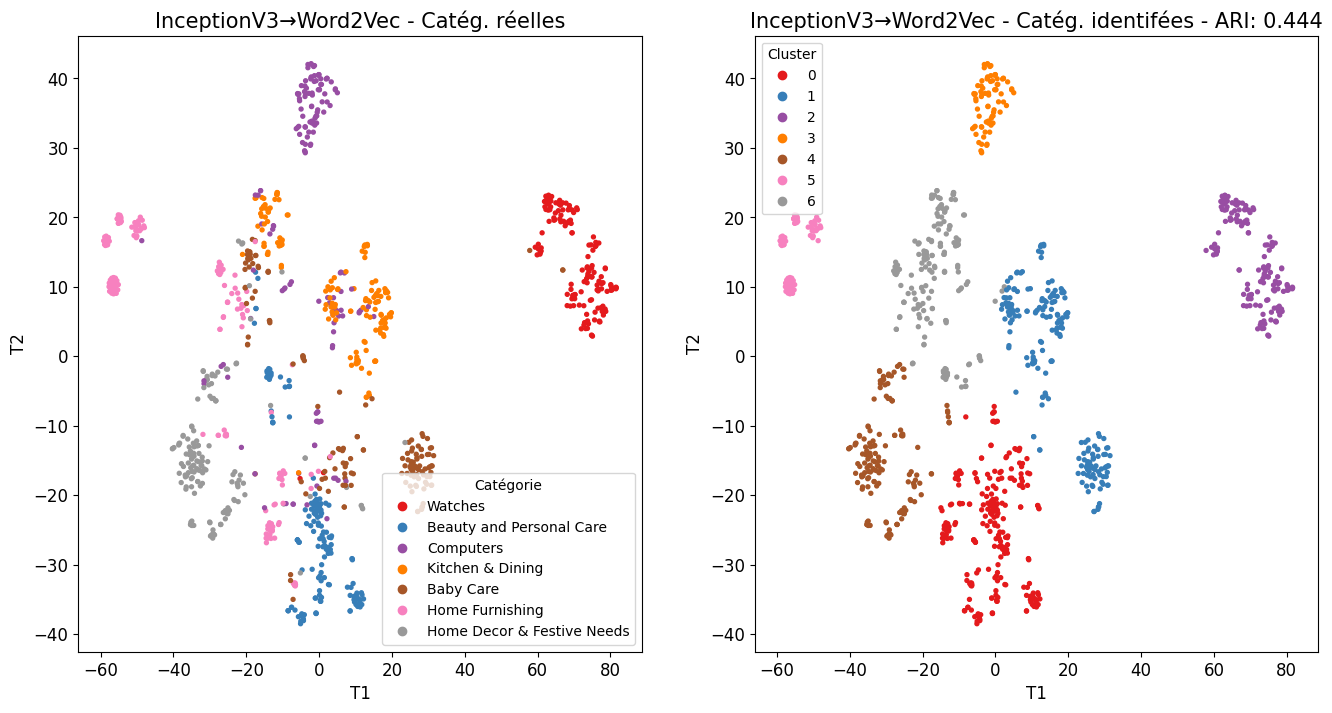

ARI : 0.4435

Colonne pour le corpus = name_desc_identif_3_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 24, 300)           1227600   
                                                                 
 global_average_pooling1d_11  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1,227,600
Trainable params: 1,227,600
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms

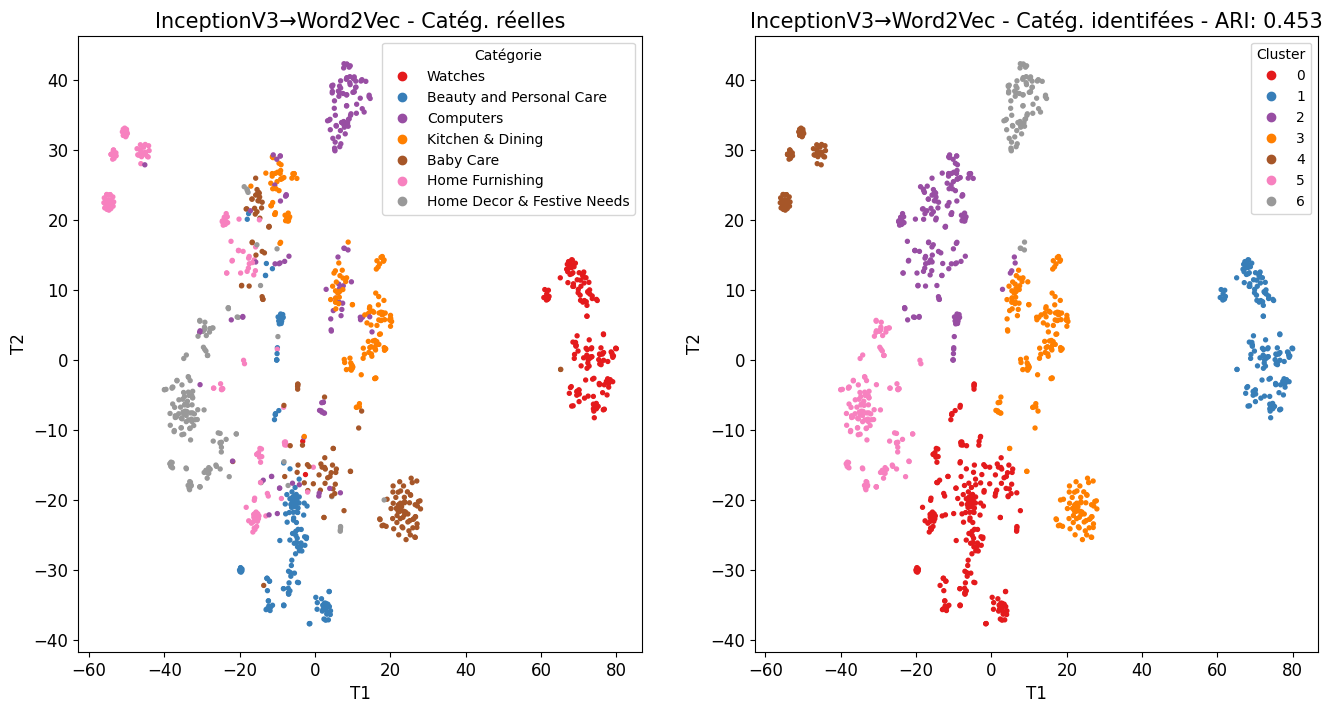

ARI : 0.4529

Colonne pour le corpus = name_identif_trusted_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 24, 300)           574500    
                                                                 
 global_average_pooling1d_12  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 574,500
Trainable params: 574,500
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 1ms/ste

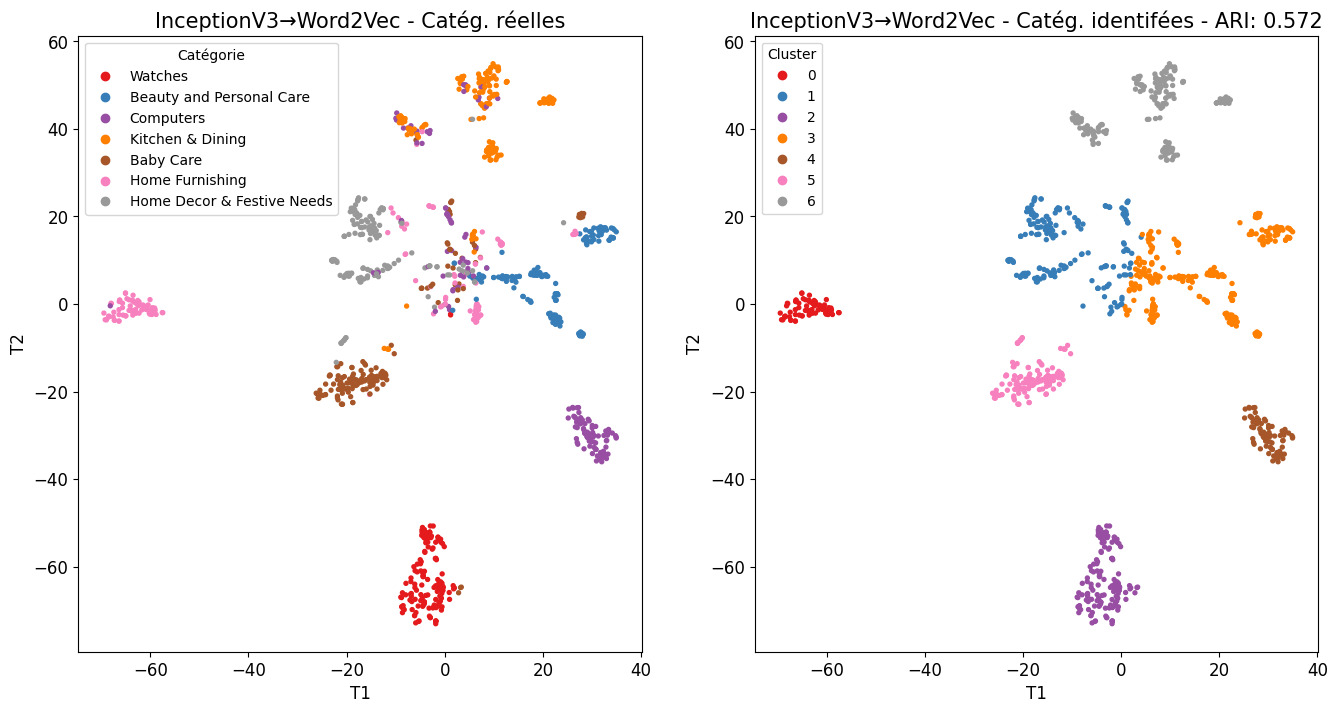

ARI : 0.5716

Colonne pour le corpus = name_identif_trusted_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 24, 300)           561300    
                                                                 
 global_average_pooling1d_13  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 561,300
Trainable params: 561,300
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0s 2ms/st

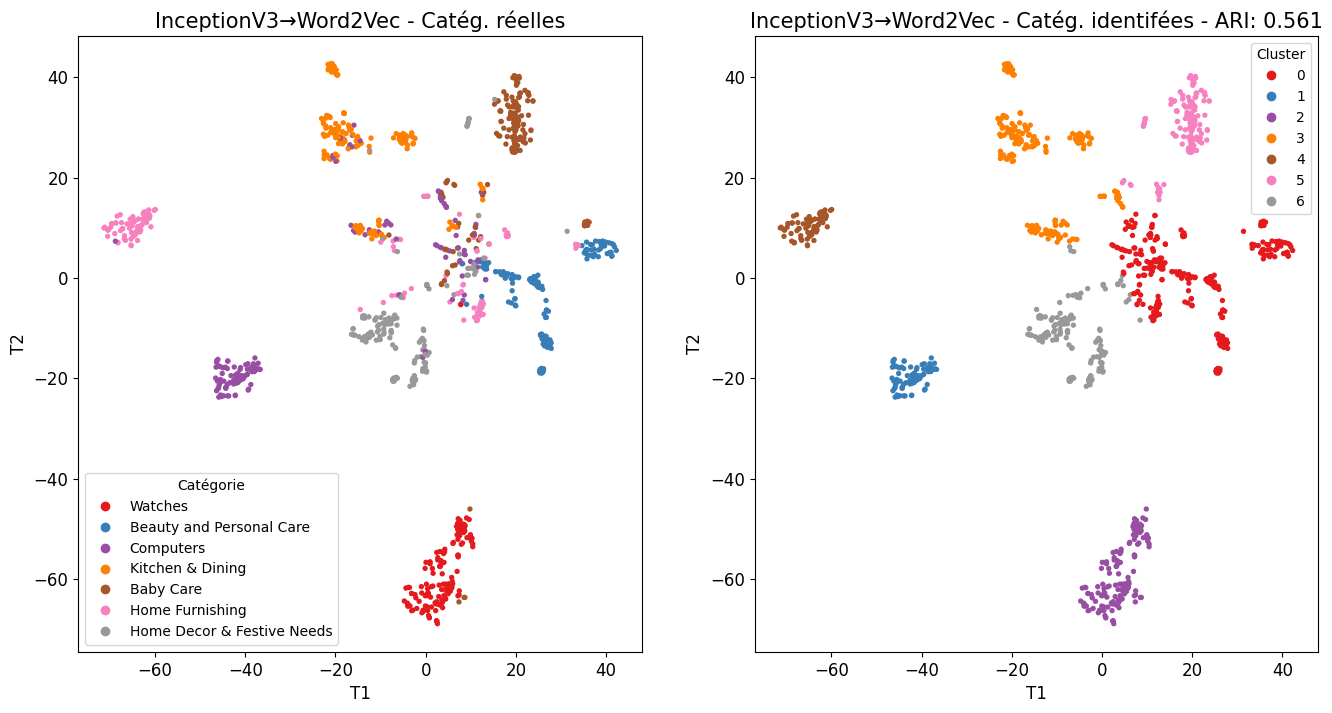

ARI : 0.5613

Colonne pour le corpus = name_desc_identif_trusted_bow_lem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 24, 300)           1347900   
                                                                 
 global_average_pooling1d_14  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1,347,900
Trainable params: 1,347,900
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 0

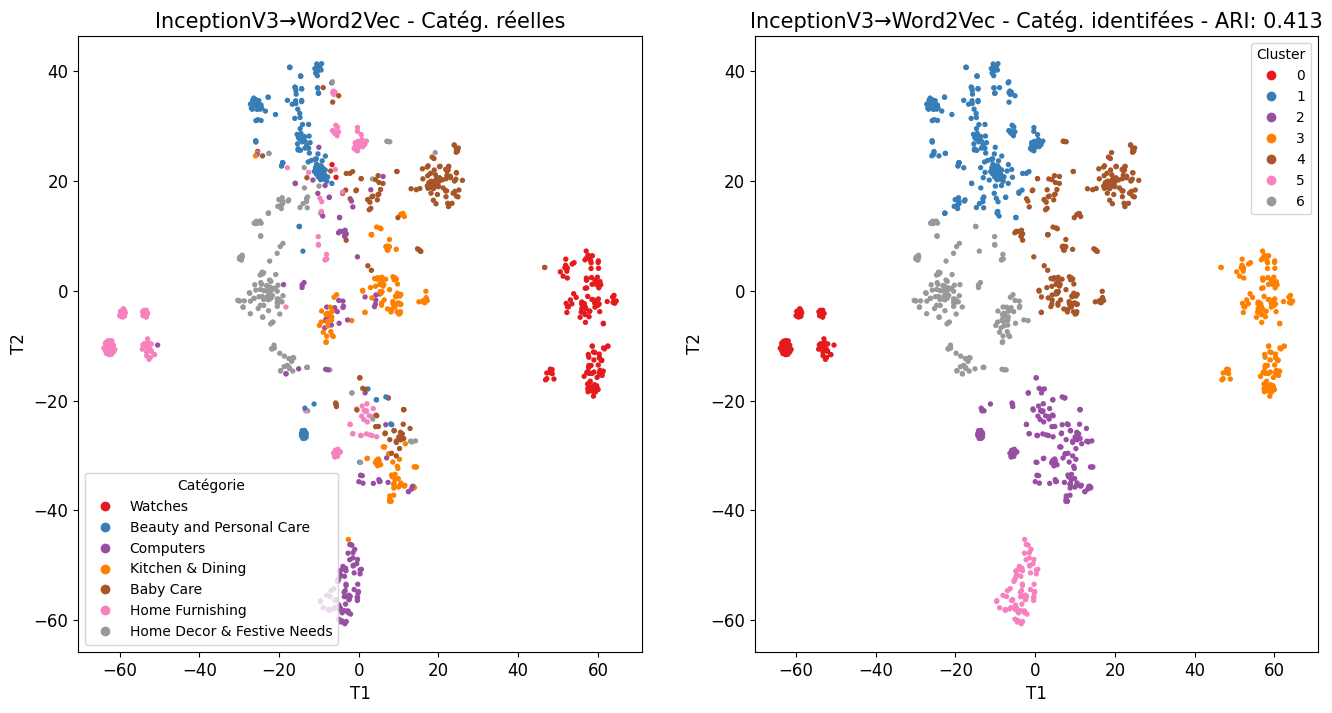

ARI : 0.4128

Colonne pour le corpus = name_desc_identif_trusted_bow_stem
Build & train Word2Vec model ...
Fit Tokenizer ...
Create Embedding matrix ...
Making Embedding model ...
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 24)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 24, 300)           1182300   
                                                                 
 global_average_pooling1d_15  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1,182,300
Trainable params: 1,182,300
Non-trainable params: 0
_________________________________________________________________
Predicting embeddings...
33/33 [==============================] - 

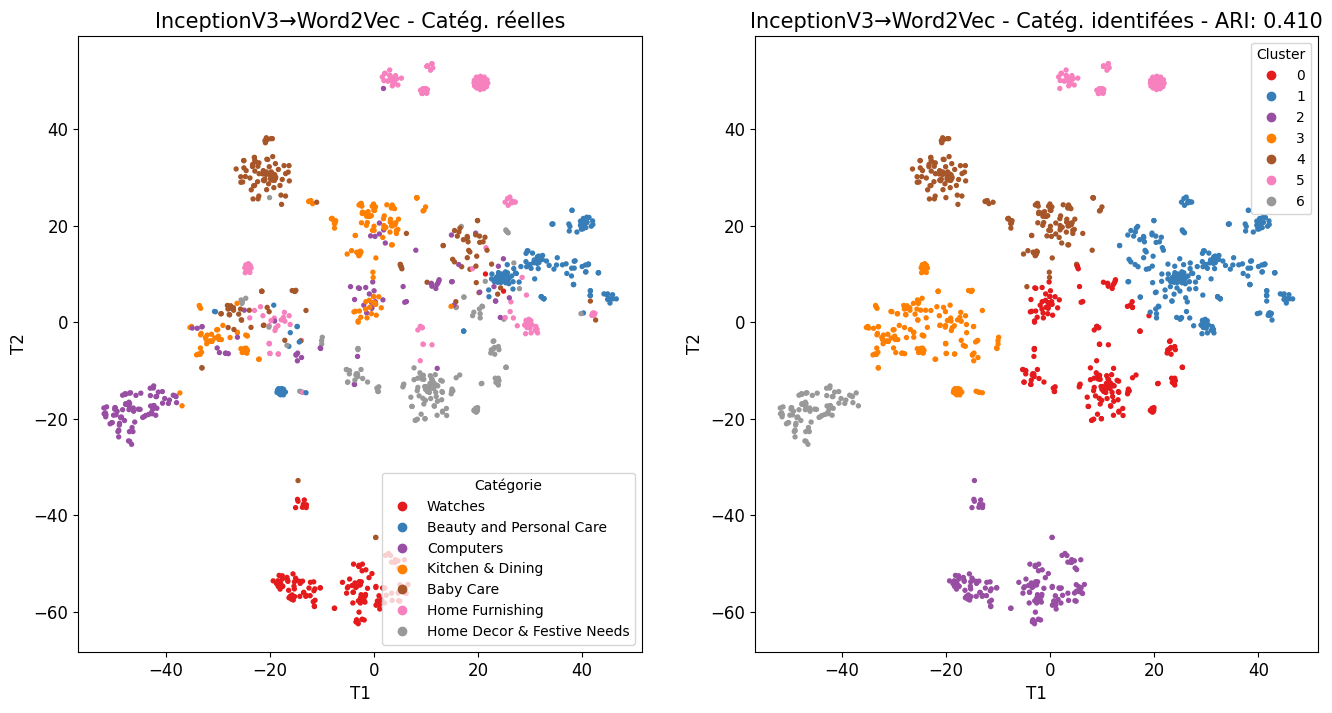

ARI : 0.4096


In [119]:
for corpus_col in ['name_identif_bow_lem', 'name_identif_bow_stem',
                   'name_desc_identif_bow_lem', 'name_desc_identif_bow_stem',
                   'name_identif_3_bow_lem', 'name_identif_3_bow_stem',
                   'name_desc_identif_3_bow_lem', 'name_desc_identif_3_bow_stem',
                   'name_identif_trusted_bow_lem', 'name_identif_trusted_bow_stem',
                   'name_desc_identif_trusted_bow_lem', 'name_desc_identif_trusted_bow_stem']:
    txt = f"Colonne pour le corpus = {corpus_col}"
    print("\n"+bcolors.HEADER+bcolors.BOLD+txt+bcolors.ENDC)
    sentences = df_all[corpus_col].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

    verbose = 1
    embeddings_word2vec = main_word2vec(sentences, w2v_size, w2v_window, w2v_min_count, w2v_epochs, maxlen, verbose=verbose)

    ARI, X_tsne, labels = ARI_fct(embeddings_word2vec, y_cat_num, n_cat)

    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    feature_extractor = 'InceptionV3→Word2Vec'
    TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Ajouter la description dégrade à chaque fois les performances de Word2vec (~0.35) !

Garder 1 ou 3 ou les prédictions fiables le rendent compétitifs (~0.60).

### USE

In [126]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [127]:
def feature_USE_fct(sentences, b_size, verbose=0) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [128]:
batch_size = 10


Colonne pour le corpus = name_identif_dl
ARI :  0.649 time :  8.0


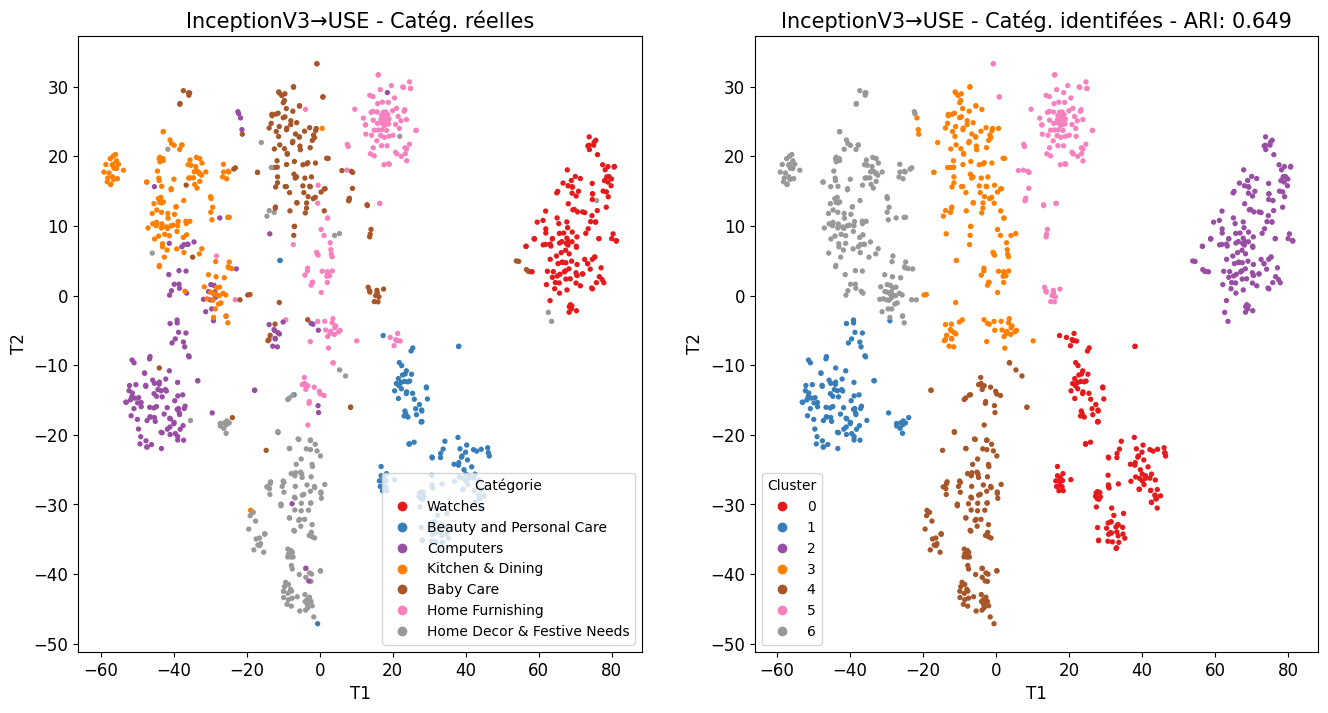

ARI : 0.6490

Colonne pour le corpus = name_desc_identif_dl
ARI :  0.5264 time :  9.0


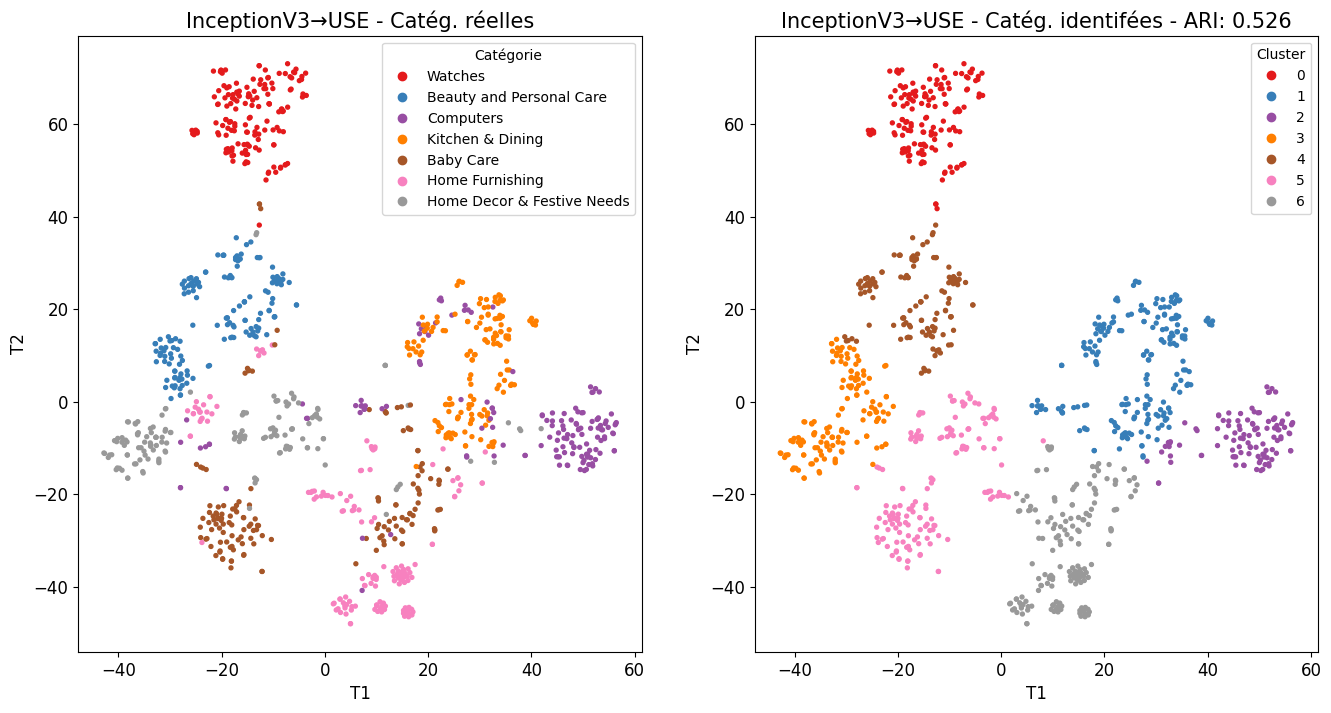

ARI : 0.5264

Colonne pour le corpus = name_identif_3_dl
ARI :  0.676 time :  12.0


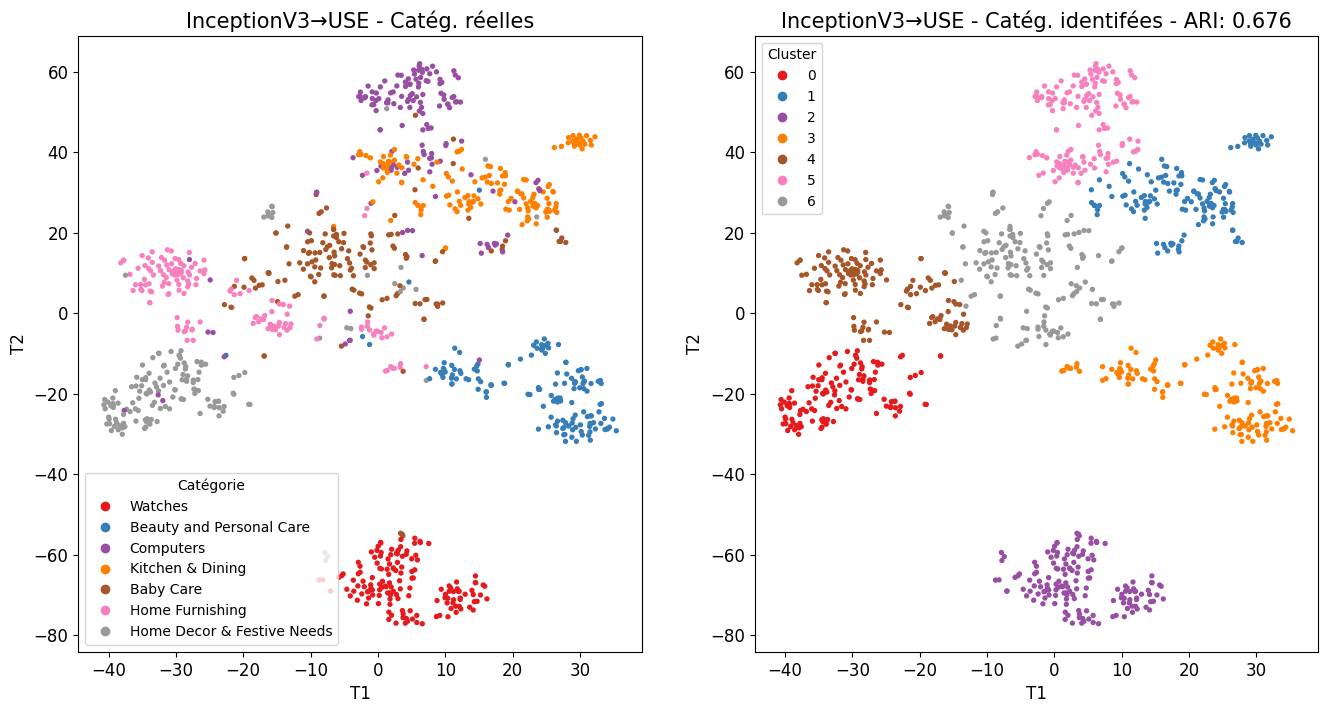

ARI : 0.6760

Colonne pour le corpus = name_desc_identif_3_dl
ARI :  0.6742 time :  12.0


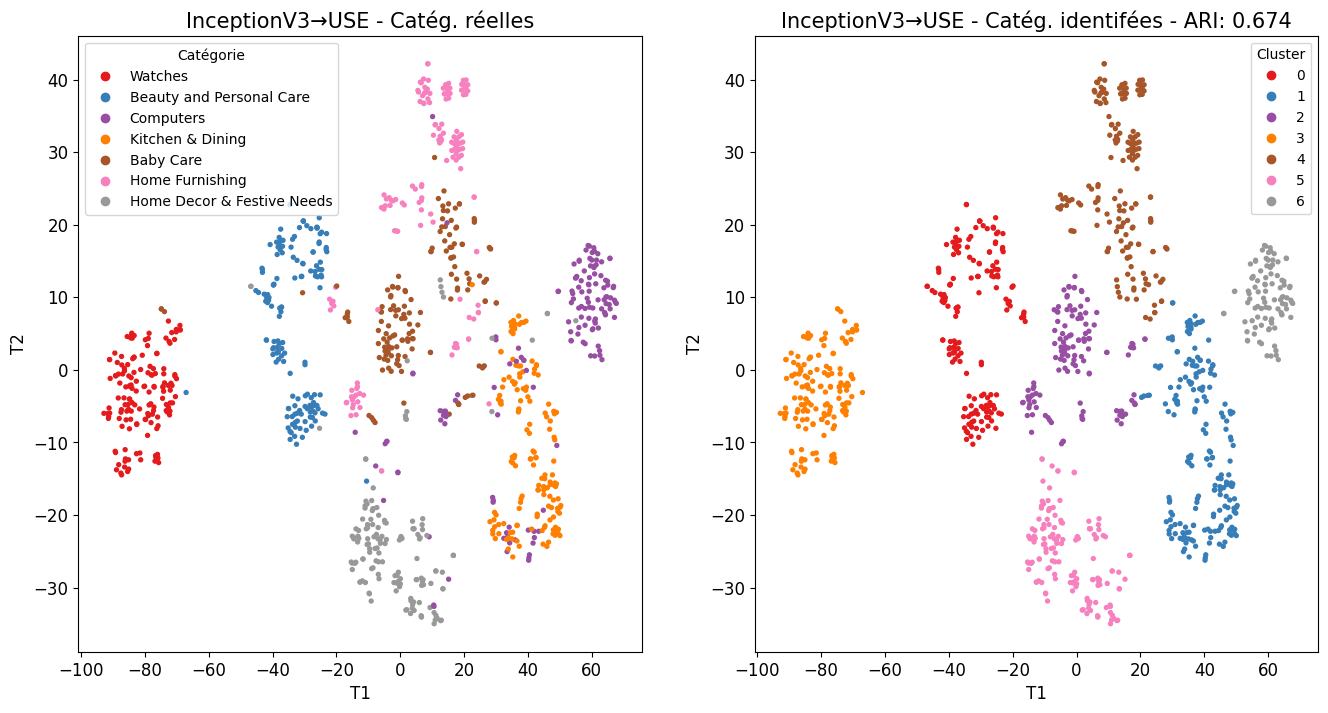

ARI : 0.6742

Colonne pour le corpus = name_identif_trusted_dl
ARI :  0.6475 time :  12.0


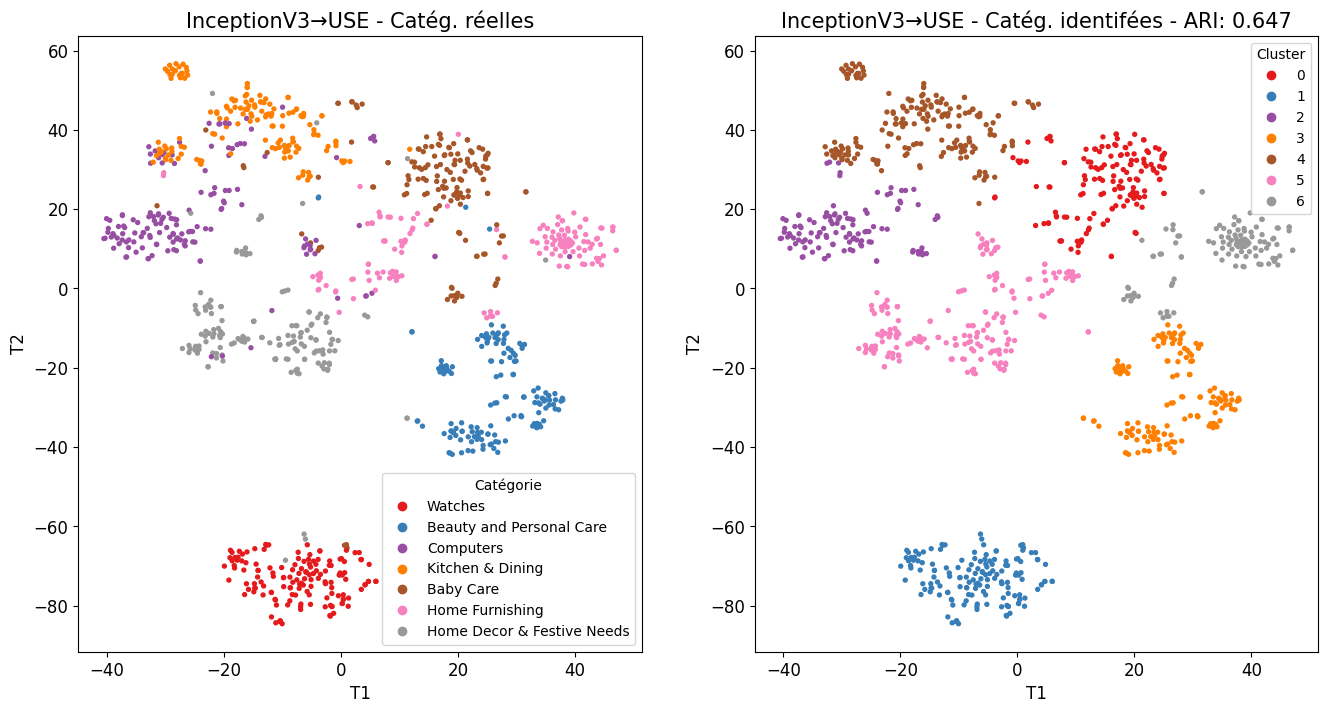

ARI : 0.6475

Colonne pour le corpus = name_desc_identif_trusted_dl
ARI :  0.4531 time :  13.0


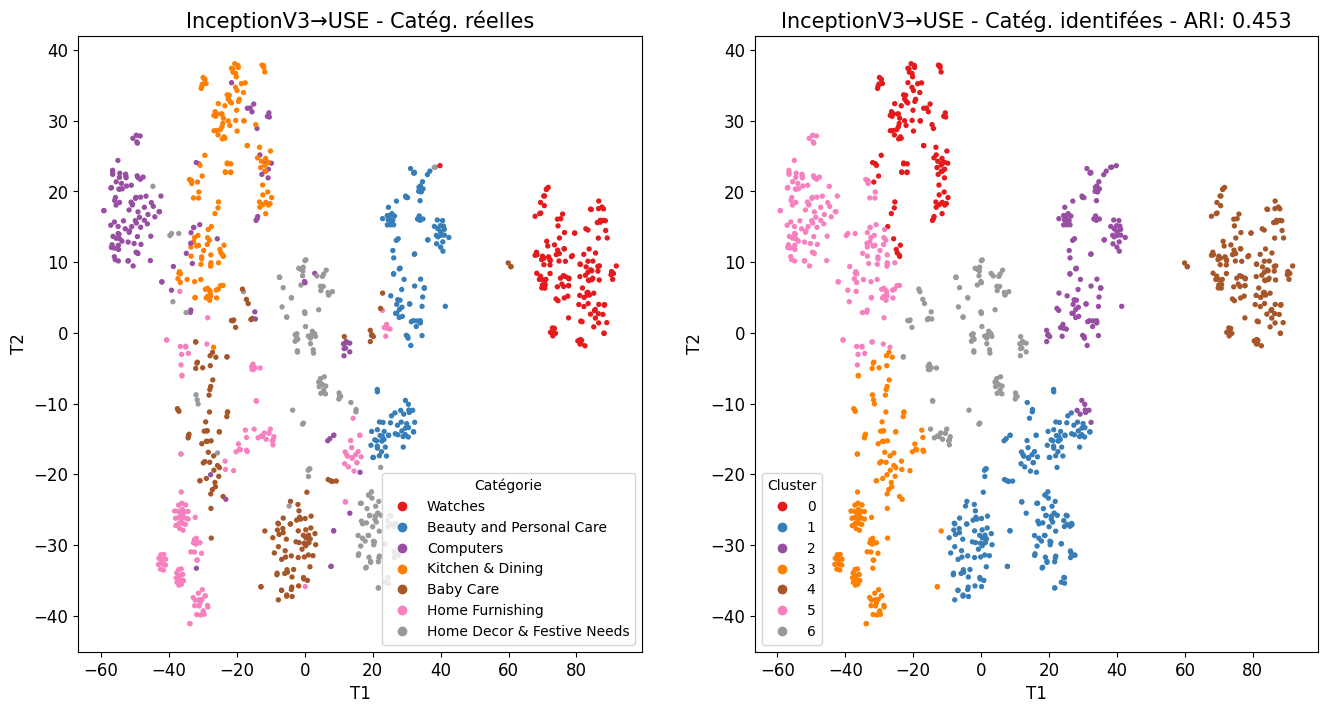

ARI : 0.4531


In [129]:
for corpus_col in ['name_identif_dl',
                   'name_desc_identif_dl',
                   'name_identif_3_dl',
                   'name_desc_identif_3_dl',
                   'name_identif_trusted_dl',
                   'name_desc_identif_trusted_dl']:
    txt = f"Colonne pour le corpus = {corpus_col}"
    print("\n"+bcolors.HEADER+bcolors.BOLD+txt+bcolors.ENDC)
    sentences = df_all[corpus_col].to_list()
    features_USE = feature_USE_fct(sentences, batch_size)
    ARI, X_tsne, labels = ARI_fct(features_USE, y_cat_num, n_cat)
    feature_extractor = 'InceptionV3→USE'
    TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

Mieux que sans l'identification mais avec la description ! 

#### Nom, descripion et identification 

In [130]:
batch_size = 10
sentences = df_all['name_desc_identif_dl'].to_list()

In [131]:
features_USE = feature_USE_fct(sentences, batch_size)

In [132]:
ARI, X_tsne, labels = ARI_fct(features_USE, y_cat_num, n_cat)

ARI :  0.5264 time :  13.0


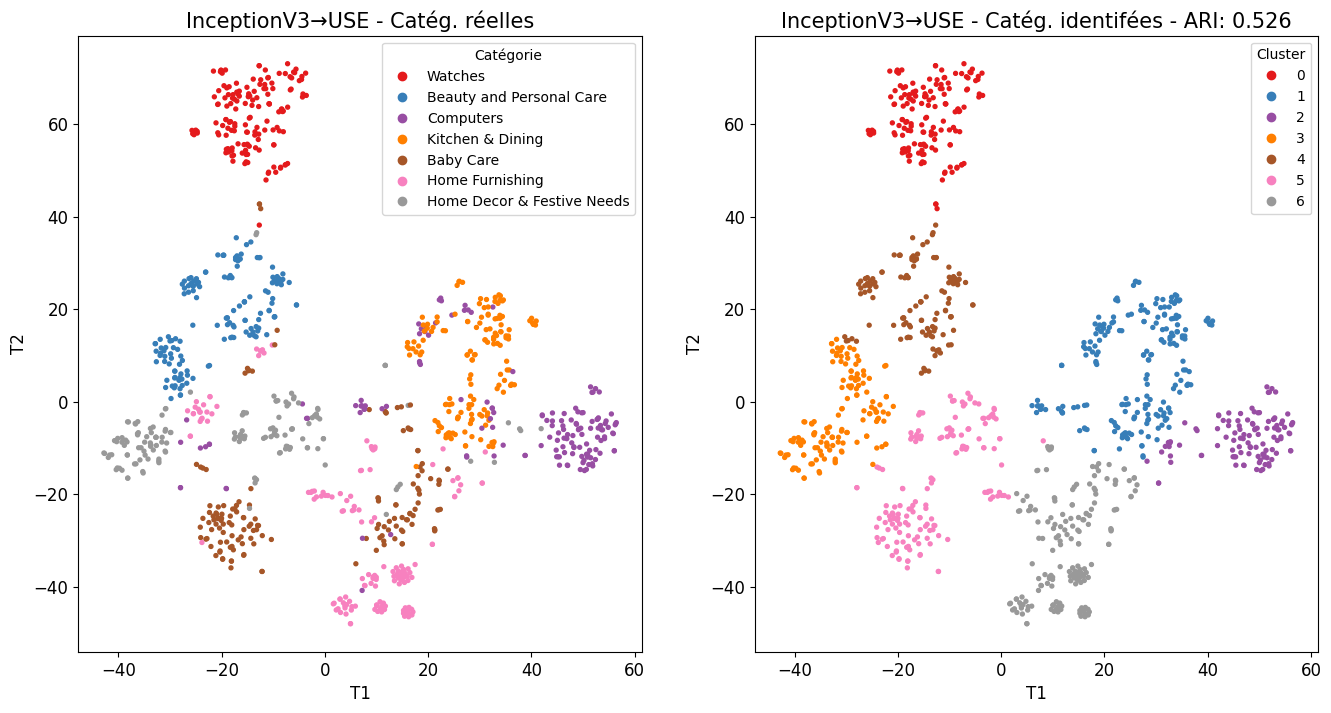

ARI : 0.5264


In [133]:
feature_extractor = 'InceptionV3→USE'
TSNE_visu_fct(X_tsne, l_cat, y_cat_num, labels, ARI, title_prefix=feature_extractor)

La combinaison texte+image ne donne décidément pas de meilleurs résultats que le texte seul.